In [1]:
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
from fuzzywuzzy import process

In [119]:
# Load the provided CSV file
file_path = "C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts\police_salaries.csv"
df = pd.read_csv(file_path, encoding='latin1')

df = df[~df['Name'].isin(['Not Provided', 'Redacted'])]

df['Total pay + benefits'] = df['Total pay'] + df['Benefits']
df['Regular pay + other pay + benefits'] = df['Regular pay'] + df['Other pay'] + df['Benefits']

df

,Year,City,Name,Job title,Regular pay,Overtime pay,Other pay,Total pay,Benefits,Pension debt,Total pay & benefits,Total pay + benefits,Regular pay + other pay + benefits
0,2011,Carlsbad,"Morrison, Gary",Police Chief,172396.81,0.00,1239.92,173636.73,86156.48,NaN,259793.21,259793.21,259793.21
1,2011,Carlsbad,"Eppel, Jarlath L.",Police Lieutenant,119550.57,46986.89,9666.26,176203.72,64488.01,NaN,240691.73,240691.73,193704.84
2,2011,Carlsbad,"Magro, Mathew T.",Police Lieutenant,119550.63,37158.40,8559.26,165268.29,67547.19,NaN,232815.48,232815.48,195657.08
3,2011,Carlsbad,"Gallucci, Aniello J.",Police Captain,145487.96,5595.69,1239.92,152323.57,75019.27,NaN,227342.84,227342.84,221747.15
4,2011,Carlsbad,"Rowland, William A.",Police Captain,145487.94,5595.69,1239.92,152323.55,75019.23,NaN,227342.78,227342.78,221747.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43460,2023,San Diego,Ryan Allen,Police Officer Ii,0.00,0.00,1019.00,1019.00,0.00,NaN,1019.00,1019.00,1019.00
43461,2023,San Diego,Michael Moore,Police Officer Ii,0.00,0.00,351.00,351.00,0.00,NaN,351.00,351.00,351.00
43462,2023,San Diego,Jorge Aguilar,Police Recruit,323.00,0.00,21.00,344.00,0.00,NaN,344.00,344.00,344.00
43463,2023,San Diego,Ariel del Toro,Police Officer Ii,0.00,0.00,18.00,18.00,0.00,NaN,18.00,18.00,18.00


In [120]:
county_df = pd.read_csv("C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts\SDCountyEmployee_data.csv", encoding='latin1')

include_filter = county_df['Position'].str.contains('|'.join(['Police']), case=False, na=False)

# Apply both filters
filtered_county_df = county_df[include_filter]

filtered_county_df

C:\Users\Ericm\AppData\Local\Temp\ipykernel_13772\2259121434.py:1: DtypeWarning: Columns (5,6,7,27) have mixed types. Specify dtype option on import or set low_memory=False.
  county_df = pd.read_csv("C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts\SDCountyEmployee_data.csv", encoding='latin1')


,Year,EmployerType,EmployerName,DepartmentOrSubdivision,Position,ElectedOfficial,Judicial,OtherPositions,MinPositionSalary,MaxPositionSalary,...,HealthDentalVision,TotalRetirementAndHealthContribution,PensionFormula,EmployerURL,EmployerPopulation,LastUpdatedDate,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
314617,2009,City,Carlsbad,Pol Communications,Police Communications Manager,NaN,NaN,NaN,80700.0,110999.0,...,11196.0,17494.0,3% @ 60,https://www.carlsbadca.gov/departments/human-r...,105319,05/13/2016,San Diego,NaN,NaN,NaN
314618,2009,City,Carlsbad,Pol Communications,Police Communications Manager,NaN,NaN,NaN,80700.0,110999.0,...,8582.0,12707.0,3% @ 60,https://www.carlsbadca.gov/departments/human-r...,105319,05/13/2016,San Diego,NaN,NaN,NaN
314619,2009,City,Carlsbad,Pol Communications,Police Reserve Officer,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,NaN,https://www.carlsbadca.gov/departments/human-r...,105319,05/13/2016,San Diego,NaN,NaN,NaN
314631,2009,City,Carlsbad,Pol Investigations,Police Corporal,NaN,NaN,NaN,67010.0,81452.0,...,7608.0,14788.0,3% @ 50,https://www.carlsbadca.gov/departments/human-r...,105319,05/13/2016,San Diego,NaN,NaN,NaN
314632,2009,City,Carlsbad,Pol Investigations,Police Corporal,NaN,NaN,NaN,67010.0,81452.0,...,12276.0,19172.0,3% @ 50,https://www.carlsbadca.gov/departments/human-r...,105319,05/13/2016,San Diego,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641395,2023,City,San Diego,Police,Senior Police Records Clerk,False,False,NaN,53539.0,64750.0,...,18.0,12589.0,2.5% @ 55,www.sandiego.gov,1385379,06/25/2024,San Diego,NaN,False,NaN
641396,2023,City,San Diego,Police,Senior Police Records Clerk,False,False,NaN,53539.0,64750.0,...,664.0,9320.0,1.0% @ 55,www.sandiego.gov,1385379,06/25/2024,San Diego,NaN,False,NaN
641397,2023,City,San Diego,Police,Senior Police Records Clerk,False,False,NaN,53539.0,64750.0,...,18939.0,24810.0,1.0% @ 55,www.sandiego.gov,1385379,06/25/2024,San Diego,NaN,False,NaN
641398,2023,City,San Diego,Police,Senior Police Records Clerk,False,False,NaN,53539.0,64750.0,...,18.0,8326.0,1.0% @ 55,www.sandiego.gov,1385379,06/25/2024,San Diego,NaN,False,NaN


In [1030]:
''''# Create a function to find the best match for a job title within a list of candidates
def find_best_match(job_title, candidates):
    best_match, score = process.extractOne(job_title, candidates)
    return best_match

# Create a dictionary to store best matches for unique positions
position_match_dict = {}
for year in df['Year'].unique():
    position_match_dict[int(year)] = {}
    for city in df['City'].unique():
        position_match_dict[int(year)][str(city)] = {}

# Iterate through each unique combination of city and year in the police_salaries_df
for (city, year), group in df.groupby(['City', 'Year']):
    # Get unique job titles for this city and year
    unique_positions = group['Job title'].unique()
    
    # Filter the SDCountyEmployee_data for the same city and year
    filtered_city_df = filtered_county_df[
        (filtered_county_df['Year'] == int(year)) &
        (filtered_county_df['EmployerName'].str.contains(str(city), case=False))
    ]
    
    # If the filtered county DataFrame is not empty, proceed with matching
    if not filtered_city_df.empty:
        city_positions = filtered_city_df['Position'].unique().tolist()
        for position in unique_positions:
            # Find the best match for each unique position in the filtered county DataFrame
            best_match = find_best_match(position, city_positions)
            if best_match:
                if position.lower() != best_match:
                    print(year, city, '|', position, ':', position_match_dict[year][city][position])
                position_match_dict[int(year)][str(city)][position] = best_match
            else:
                print('Error: No Match Found')
            
position_match_dict'''

{2020: {'Escondido': {'Police Sergeant': 'Police Sergeant',
   'Police Officer': 'Police Officer',
   'Police Records Technician': 'Police Records Technician',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Executive Asst-Chief Of Police': 'Executive Asst-Chief Of Police',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Chief Of Police': 'Chief Of Police',
   'Police Captain': 'Police Captain',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Police Business Mgr': 'Police Business Manager',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Services Analyst': 'Police Services Analyst',
   'Dept Spec/Police Records Tech': 'Department Spec/Police Records Tech'},
  'San Diego': {'Police Officer': 'Police Officer 1',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Property & Evid Spec': 'Police Property & Evidence Spec',
   'Police Dispatch Supv': 'Police Dispa

In [121]:
#Resulting dictionary from above cell to avoid computation time
position_match_dict = {2020: {'Escondido': {'Police Sergeant': 'Police Sergeant',
   'Police Officer': 'Police Officer',
   'Police Records Technician': 'Police Records Technician',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Executive Asst-Chief Of Police': 'Executive Asst-Chief Of Police',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Chief Of Police': 'Chief Of Police',
   'Police Captain': 'Police Captain',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Police Business Mgr': 'Police Business Manager',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Services Analyst': 'Police Services Analyst',
   'Dept Spec/Police Records Tech': 'Department Spec/Police Records Tech'},
  'San Diego': {'Police Officer': 'Police Officer 1',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Property & Evid Spec': 'Police Property & Evidence Spec',
   'Police Dispatch Supv': 'Police Dispatch Supervisor',
   'Police Dispatcher': 'Police Dispatcher',
   'Sr Police Records Clerk': 'Police Records Clerk',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Invstgtv Serv Ofcr 2': 'Police Detective',
   'Police Dispatch Admnstr': 'Police Dispatch Administer',
   'Police Serv Ofcr 2(Indochinese Srv Of 2)': 'Police Services Officer 2(Indochinese Srv Of 2)',
   'Police Property & Evid Supv': 'Police Detective',
   'Police Code Compl Ofcr': 'Police Captain',
   'Police Invstgtv Serv Ofcr 1': 'Police Detective',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief',
   'Sr Police Prop & Evid Supv': 'Police Detective',
   'Conf Secretary To Police Chief': 'Conf Secretary To Police Chief',
   'Police Serv Ofcr 2(African Srv Ofcr)': 'Police Services Officer 2(African Srv Officer)'},
  'La Mesa': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Services Spec-Temp': 'Police Services Spec-Temp',
   'Police Services Tech.': 'Police Services Tech.',
   'Police Sergeant': 'Police Sergeant',
   'Police Prop Officer I': 'Police Prop Officer I',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Ser Tech-Temp/Pers': 'Police Services Tech-Temp/Pers',
   'Police Srvs Specialist': 'Police Services Specialist',
   'Police Services Manager': 'Police Services Manager',
   'Police Prop Officer Ii': 'Police Prop Officer II',
   'Police Captain': 'Police Captain',
   'Police Services Tech-Temp': 'Police Services Tech-Temp',
   'Police Chief': 'Police Chief'},
  'Carlsbad': {'Police Officer': 'Police Officer',
   'Police Corporal': 'Police Corporal',
   'Police Ranger': 'Police Ranger',
   'H/Ret Annuitant Police Officer': 'H/Ret Annuitant Police Officer',
   'Police Rec Specialist Ii': 'Police Rec Specialist II',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Chief': 'Police Chief',
   'Police Records Specialist I': 'Police Records Specialist I',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Records Specialist Iijs': 'Police Records Specialist IIjs',
   'Police Records Specialist Ii - Js': 'Police Records Specialist II - Js',
   'Police Captain': 'Police Captain',
   'Police Records Specialist Ii': 'Police Records Specialist II',
   'Assistant Police Chief': 'Assistant Police Chief'},
  'Oceanside': {'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Technician': 'Police Records Technician',
   'Police Captain': 'Police Captain',
   'Police Cadet': 'Police Cadet',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Police Chief': 'Police Chief',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Services Officer Ii': 'Police Services Officer II',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Police Corporal': 'Police Corporal',
   'Police Support Services Manager': 'Police Support Services Manager',
   'Police Sergeant': 'Police Sergeant',
   'Police Com. Relations Coord.': 'Police Com. Relations Coordinator.',
   'Director Of Police Services': 'Director Of Police Services',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain',
   'Police Services Officer I': 'Police Services Officer I'},
  'Chula Vista': {'Police Recruit': 'Police Recruit',
   'Police Cadet': 'Police Cadet',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Admin Srvcs Admnstrtr': 'Chief Of Police',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Sergeant': 'Police Sergeant',
   'Police Agent': 'Police Agent',
   'Police Services Officer': 'Police Services Officer',
   'Police Dispatcher Trainee': 'Police Dispatcher Trainee',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Records & Support Supv': 'Police Records & Support Supervisor',
   'Police Services Officer Supv': 'Police Services Officer',
   'Police Captain': 'Police Captain',
   'Police Communications Sys Mgr': 'Police Communications Sys Manager',
   'Police Comm Relations Spec': 'Police Comm Relations Spec',
   'Police Support Services Aide': 'Police Support Services Aide',
   'Police Support Services Mgr': 'Police Support Services Manager',
   'Police Technology Specialist': 'Police Technology Specialist',
   'Police Dispatcher Supervisor': 'Police Dispatcher Supervisor',
   'Chief Of Police': 'Chief Of Police',
   'Police Facility & Supply Coord': 'Police Facility & Supply Coordinator'},
  'El Cajon': {'Police Services Officer': 'Police Services Officer',
   'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Manager': 'Police Records Manager',
   'Police Corporal': 'Police Corporal',
   'Police Recruit': 'Police Recruit',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Supervising Police Dispatcher': 'Supervising Police Dispatcher',
   'Police Captain': 'Police Captain',
   'Executive Assistant To Police Chief': 'Executive Assistant To Police Chief',
   'Police Chief': 'Police Chief'}},
 2021: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Records Technician': 'Police Records Technician',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Executive Asst-Chief Of Police': 'Executive Asst-Chief Of Police',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Police Business Mgr': 'Police Business Mgr.',
   'Chief Of Police': 'Chief Of Police',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Services Analyst': 'Police Services Analyst',
   'Dept Spec/Police Records Tech': 'Dept Spec/Police Records Tech'},
  'San Diego': {'Police Officer': 'Police Officer I',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Property And Evidence Specialist': 'Police Property And Evidence Specialist',
   'Police Property And Evidence Supervisor': 'Police Property And Evidence Supervisor',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Police Dispatcher': 'Police Dispatcher',
   'Senior Police Records Clerk': 'Senior Police Records Clerk',
   'Police Investigative Service Officer Ii': 'Police Investigative Service Officer II',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Dispatch Administrator': 'Police Dispatch Administrator',
   'Police Service Officer Ii': 'Police Service Officer II',
   'Police Code Compliance Officer': 'Police Code Compliance Officer',
   'Police Investigative Service Officer I': 'Police Investigative Service Officer I',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief',
   'Senior Police Property And Evidence Supervisor': 'Senior Police Property And Evidence Supervisor',
   'Confidential Secretary To Police Chief': 'Confidential Secretary To Police Chief'},
  'La Mesa': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Services Spec-Temp': 'Police Services Spec-Temp',
   'Police Services Tech.': 'Police Services Tech.',
   'Police Sergeant': 'Police Sergeant',
   'Police Prop Officer I': 'Police Prop Officer I',
   'Police Prop Officer Ii': 'Police Prop Officer II',
   'Police Ser Tech-Temp/Pers': 'Police Ser Tech-Temp/Pers',
   'Police Srvs Specialist': 'Police Srvs Specialist',
   'Police Services Manager': 'Police Services Manager',
   'Police Captain': 'Police Captain',
   'Police Services Tech-Temp': 'Police Services Tech-Temp',
   'Police Chief': 'Police Chief'},
  'Carlsbad': {'Police Officer': 'Police Officer',
   'Police Recruit': 'Police Recruit',
   'Police Sergeant': 'Police Sergeant',
   'Police Ranger': 'Police Ranger',
   'Police Records Specialist Ii': 'Police Records Specialist II',
   'Police Corporal': 'Police Corporal',
   'Police Captain': 'Police Captain',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Specialist I': 'Police Records Specialist I',
   'Police Chief': 'Police Chief',
   'Police Communications Manager': 'Police Communications Manager',
   'Assistant Police Chief': 'Assistant Police Chief',
   'Hourly/Ret. Anuit. Police Ofc': 'Hourly/Ret. Anuit. Police Ofc'},
  'Oceanside': {'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Technician': 'Police Records Technician',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Police Chief': 'Police Chief',
   'Police Public Information Officer': 'Police Public Information Officer',
   'Police Cadet': 'Police Cadet',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Captain': 'Police Captain',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {'Police Officer': 'Police Officer',
   'Senior Police Dispatcher': 'Senior Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Sergeant': 'Police Sergeant',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Investigator': 'Police Investigator',
   'Police Corporal': 'Police Corporal',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Records Clerk': 'Police Records Clerk',
   'Reserve Police Officer': 'Reserve Police Officer',
   'Police Operations Assistant': 'Police Operations Assistant',
   'Police Captain': 'Police Captain',
   'Police Support Services Mgr.': 'Police Support Services Mgr.',
   'Police Chief': 'Police Chief'},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Services Officer Ii': 'Police Services Officer II',
   'Police Support Services Manager': 'Police Support Services Manager',
   'Police Sergeant': 'Police Sergeant',
   'Police Corporal': 'Police Corporal',
   'Police Com. Relations Coord.': 'Police Com. Relations Coord.',
   'Police Lieutenant': 'Police Lieutenant',
   'Director Of Police Services': 'Director Of Police Services',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Police Captain': 'Police Captain'},
  'Chula Vista': {'Police Lieutenant': 'Police Lieutenant',
   'Police Recruit': 'Police Recruit',
   'Police Admin Svcs Administratr': 'Police Admin Svcs Administrator',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Sergeant': 'Police Sergeant',
   'Police Agent': 'Police Agent',
   'Police Dispatcher Trainee': 'Police Dispatcher Trainee',
   'Police Services Officer': 'Police Services Officer',
   'Police Records & Support Supv': 'Police Records & Support Supv',
   'Police Captain': 'Police Captain',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Communications Sys Mgr': 'Police Communications Sys Mgr.',
   'Police Comm Relations Spec': 'Police Comm Relations Spec',
   'Police Support Services Aide': 'Police Support Services Aide',
   'Police Technology Manager': 'Police Technology Manager',
   'Police Support Services Mgr': 'Police Support Services Mgr.',
   'Police Technology Specialist': 'Police Technology Specialist',
   'Police Dispatcher Supervisor': 'Police Dispatcher Supervisor',
   'Senior Police Records Spec': 'Senior Police Records Spec',
   'Chief Of Police': 'Chief Of Police',
   'Police Facility & Supply Coord': 'Police Facility & Supply Coord'},
  'El Cajon': {'Police Officer': 'Police Officer',
   'Police Services Officer': 'Police Services Officer',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Sergeant': 'Police Sergeant',
   'Police Corporal': 'Police Corporal',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Supervising Police Dispatcher': 'Supervising Police Dispatcher',
   'Police Captain': 'Police Captain',
   'Police Records Manager': 'Police Records Manager',
   'Executive Assistant To Police Chief': 'Executive Assistant To Police Chief',
   'Police Recruit': 'Police Recruit',
   'Police Chief': 'Police Chief'}},
 2023: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Technician': 'Police Records Technician',
   'Police Lieutenant': 'Police Lieutenant',
   'Executive Asst-Chief Of Police': 'Executive Asst-Chief Of Police',
   'Police Captain': 'Police Captain',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Dep Dir Of Police Support Svc': 'Dep Dir Of Police Support Svc',
   'Chief Of Police': 'Chief Of Police',
   'Police Business Manager': 'Police Business Manager',
   'Dept Spec/Police Records Tech': 'Dept. Spec/Police Records Tech'},
  'San Diego': {'Police Dispatcher': 'Police Dispatcher',
   'Police Officer Ii': 'Police Officer II',
   'Police Detective': 'Police Detective',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Officer I': 'Police Officer I',
   'Police Sergeant': 'Police Sergeant',
   'Police Recruit': 'Police Recruit',
   'Police Lieutenant': 'Police Lieutenant',
   'Assistant Police Chief': 'Assistant Police Chief',
   'Police Property And Evidence Specialist': 'Police Property And Evidence Specialist',
   'Police Property And Evidence Supervisor': 'Police Property And Evidence Supervisor',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Senior Police Records Clerk': 'Senior Police Records Clerk',
   'Police Officer Iii': 'Police Officer III',
   'Police Investigative Service Officer Ii': 'Police Investigative Service Officer II',
   'Police Dispatch Administrator': 'Police Dispatch Administrator',
   'Police Service Officer Ii': 'Police Service Officer II',
   'Senior Police Property And Evidence Supervisor': 'Senior Police Property And Evidence Supervisor',
   'Police Code Compliance Officer': 'Police Code Compliance Officer',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Investigative Service Officer I': 'Police Investigative Service Officer I',
   'Police Captain': 'Police Captain',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief',
   'Confidential Secretary To Police Chief': 'Confidential Secretary To Police Chief',
   'Police Service Officer I': 'Police Service Officer I',
   'Police Chief': 'Police Chief',
   'Police Special Project Manager': 'Police Special Project Manager'},
  'La Mesa': {},
  'Carlsbad': {'Police Officer': 'Police Officer',
   'Police Corporal': 'Police Corporal',
   'Police Administrative Manager': 'Police Administrative Manager',
   'Police Sergeant': 'Police Sergeant',
   'Police Recruit': 'Police Recruit',
   'Police Ranger': 'Police Ranger',
   'Assistant Police Chief': 'Assistant Police Chief',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Specialist Ii': 'Police Records Specialist II',
   'Police Captain': 'Police Captain',
   'Hourly/Ret. Anuit. Police Ofc': 'Hourly/Ret. Anuit. Police Ofc',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Records Specialist I': 'Police Records Specialist I',
   'Police Chief': 'Police Chief'},
  'Oceanside': {'Police Officer': 'Police Officer',
   'Police Chief': 'Police Chief',
   'Police Public Information Officer': 'Police Public Information Officer',
   'Police Cadet': 'Police Cadet',
   'Police Records Technician': 'Police Records Technician',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Captain': 'Police Captain',
   'Assistant Police Chief': 'Assistant Police Chief',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Services Officer Ii': 'Police Services Officer II',
   'Police Sergeant': 'Police Sergeant',
   'Police Corporal': 'Police Corporal',
   'Police Com. Relations Coord.': 'Police Com. Relations Coord.',
   'Police Lieutenant': 'Police Lieutenant',
   'Director Of Police Services': 'Director Of Police Services',
   'Police Captain': 'Police Captain',
   'Police Support Services Manager': 'Police Support Services Manager',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Executive Assistant To The Police Chief': 'Executive Assistant To The Police Chief'},
  'Chula Vista': {},
  'El Cajon': {'Police Officer': 'Police Officer',
   'Police Services Officer I': 'Police Services Officer I',
   'Police Dispatcher Ii': 'Police Dispatcher II',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Services Officer Ii': 'Police Services Officer II',
   'Police Records Manager': 'Police Records Manager',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Corporal': 'Police Corporal',
   'Police Dispatcher Ii Nightshft': 'Police Dispatcher II Nightshift',
   'Police Dispatcher I': 'Police Dispatcher I',
   'Police Records Supv': 'Executive Assistant To Police Chief',
   'Ex Assist To Police Chief': 'Police Chief',
   'Police Recruit': 'Police Recruit',
   'Police Chief': 'Police Chief',
   'Super Police Dispatcher Ns': 'Super Police Dispatcher NS',
   'Super Police Dispatcher': 'Super Police Dispatcher',
   'Police Captain': 'Police Captain'}},
 2016: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Executive Asst-Chief of Police': 'Executive Asst-Chief of Police',
   'Police Sergeant': 'Police Sergeant',
   'Asst Chief of Police': 'Asst Chief of Police',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Chief Of Police': 'Chief Of Police',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Busines Mgr': 'Police Busines Mgr',
   'Police Records Technician': 'Police Records Technician',
   'Police Captain': 'Police Captain',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Police Records Manager': 'Police Records Manager',
   'Dept Spec/Police Records Tech': 'Dept Spec/Police Records Tech'},
  'San Diego': {'Police Officer': 'Police Officer 2',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Property & Evid Clrk': 'Police Property & Evid Clrk',
   'Police Dispatch Supv': 'Police Dispatch Supv',
   'Police Dispatcher': 'Police Dispatcher',
   'Sr Police Records Clerk': 'Sr Police Records Clerk',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Invstgtv Serv Ofcr 2': 'Police Invstgtv Serv Ofcr 2',
   'Police Dispatch Admnstr': 'Police Dispatch Admnstr',
   'Police Records Data Spec': 'Police Records Data Spec',
   'Police Serv Ofcr 2(Indochinese Srv Of 2)': 'Police Serv Ofcr 2(Indochinese Srv Of 2)',
   'Police Code Compl Ofcr': 'Police Code Compl Ofcr',
   'Police Invstgtv Serv Ofcr 1': 'Police Invstgtv Serv Ofcr 1',
   'Police Serv Ofcr 2(African Srv Ofcr)': 'Police Serv Ofcr 2(African Srv Ofcr)',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief',
   'Conf Secretary to Police Chief': 'Conf Secretary to Police Chief',
   'Police Serv Ofcr 1(Indochinese Srv Ofcr)': 'Police Serv Ofcr 1(Indochinese Srv Ofcr)',
   'Police Invstgtv Serv Ofcr 2(Lt Pn Ex Ad)': 'Police Invstgtv Serv Ofcr 2(Lt Pn Ex Ad)',
   'Police Records Data Spec Supv': 'Police Records Data Spec Supv'},
  'La Mesa': {'POLICE SERVICES TECH.': 'Police Services Tech.',
   'POLICE OFFICER': 'Police Officer',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE SERVICES TECH-TEMP': 'Police Services Tech-Temp',
   'POLICE SERGEANT': 'Police Sergeant',
   'POLICE SER TECH-TEMP/PERS': 'Police Ser Tech-Temp/Pers',
   'POLICE SRVS SPECIALIST': 'Police Srvs Specialist',
   'POLICE SERVICES MANAGER': 'Police Services Manager',
   'POLICE PROPERTY OFFICER': 'Police Property Officer',
   'POLICE CHIEF': 'Police Chief',
   'POLICE OFFICER TRAINEE': 'Police Officer Trainee'},
  'Carlsbad': {'Police Recruit': 'Police Recruit',
   'Police Officer': 'Police Officer',
   'Police Corporal': 'Police Corporal',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Specialist II': 'Police Records Specialist II',
   'Police Chief': 'Police Chief',
   'H/Ret Annuitant Police Officer': 'H/Ret Annuitant Police Officer',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Records Specialist IIJS': 'Police Records Specialist IIJS',
   'Police Captain': 'Police Captain'},
  'Oceanside': {'Police Captain': 'Police Captain',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Records Technician': 'Police Records Technician',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Cadet': 'Police Cadet',
   'Police Chief': 'Police Chief',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Sergeant': 'Police Sergeant',
   'Police Corporal': 'Police Corporal',
   'Reserve Police Officer': 'Reserve Police Officer',
   'Police Captain': 'Police Captain',
   'Police Investigator': 'Police Investigator',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Operations Assistant': 'Police Operations Assistant',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Senior Police Dispatcher': 'Senior Police Dispatcher',
   'Police Recruit': 'Police Recruit',
   'Police Chief': 'Police Chief'},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Services Officer II': 'Police Services Officer II',
   'Police Dispatch/Records Asst.': 'Police Dispatch/Records Asst.',
   'Police Corporal': 'Police Corporal',
   'Police Support Services Supervisor': 'Police Support Services Supervisor',
   'Police Com. Relations Coord.': 'Police Com. Relations Coord.',
   'Police Sergeant': 'Police Sergeant',
   'Director of Police Services': 'Director of Police Services',
   'Police Services Officer I': 'Police Services Officer I',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Commander': 'Police Commander'},
  'Chula Vista': {'POLICE SERGEANT': 'Police Sergeant',
   'POLICE ADMIN SVCS ADMINISTRATO': 'Police Admin Svcs Administrato',
   'POLICE AGENT': 'Police Agent',
   'POLICE SERVICES OFFICER': 'Police Services Officer',
   'POLICE RECRUIT': 'Police Recruit',
   'POLICE RECORDS SPEC (HOURLY)': 'Police Records Spec (Hourly)',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE RECORDS SPECIALIST': 'Police Records Specialist',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'CHIEF OF POLICE': 'Chief Of Police',
   'POLICE SUPPORT SERVICES MGR': 'Police Support Services Mgr',
   'SR POLICE RECORDS SPECIALIST': 'Sr Police Records Specialist',
   'POLICE CADET': 'Police Cadet',
   'POLICE DISPATCHER SUPERVISOR': 'Police Dispatcher Supervisor',
   'POLICE COMM RELATIONS SPEC': 'Police Comm Relations Spec',
   'POLICE TECHNOLOGY SPECIALIST': 'Police Technology Specialist',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE TECH SPECIALIST (HRLY)': 'Police Tech Specialist (HRly)',
   'POLICE SVCS OFFICER SUPERVISOR': 'Police Svcs Officer Supervisor',
   'POLICE TECHNOLOGY MANAGER': 'Police Technology Manager'},
  'El Cajon': {'Police Services Officer': 'Police Services Officer',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Offier': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Captain': 'Police Captain',
   'Police Recruit': 'Police Recruit',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Chief': 'Police Chief',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Dispatcher Supervisor': 'Police Dispatcher Supervisor',
   'Police Record Manager': 'Police Record Manager'}},
 2017: {'Escondido': {'Police Officer': 'Police Officer',
   'Executive Asst-Chief of Police': 'Executive Assistant-Chief Of Police',
   'Police Sergeant': 'Police Sergeant',
   'Dept Spec/Police Records Tech': 'Department Spec/Police Records Tech',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Chief Of Police': 'Chief Of Police',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Police Records Technician': 'Police Records Technician',
   'Police Busines Mgr': 'Police Business Manager',
   'Police Captain': 'Police Captain',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Police Services Analyst': 'Police Services Analyst'},
  'San Diego': {'Police Officer': 'Police Officer II',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Property & Evid Spec': 'Police Detective',
   'Police Dispatch Supv': 'Police Dispatch Supervisor',
   'Police Dispatcher': 'Police Dispatcher',
   'Sr Police Records Clerk': 'Police Records Clerk',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Invstgtv Serv Ofcr 1': 'Police Detective',
   'Police Invstgtv Serv Ofcr 2': 'Police Detective',
   'Police Dispatch Admnstr': 'Police Dispatch Admin',
   'Police Records Data Spec Supv': 'Police Detective',
   'Police Property & Evid Supv': 'Police Detective',
   'Police Code Compl Ofcr': 'Police Captain',
   'Police Serv Ofcr 2(Indochinese Srv Of 2)': 'Police Detective',
   'Police Records Data Spec': 'Police Records Data Specialist Supervisor',
   'Police Serv Ofcr 2(African Srv Ofcr)': 'Police Detective',
   'Police Property & Evid Clrk': 'Police Property & Evidence Clerk',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief',
   'Conf Secretary to Police Chief': 'Conf Secretary To Police Chief',
   'Police Serv Ofcr 1(Indochinese Srv Ofcr)': 'Police Detective',
   'Police Invstgtv Serv Ofcr 2(Lt Pn Ex Ad)': 'Police Detective'},
  'La Mesa': {'POLICE OFFICER': 'Police Officer',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE SERVICES TECH-TEMP': 'Police Services Tech-Temp',
   'POLICE SERVICES TECH.': 'Police Services Tech.',
   'POLICE SERGEANT': 'Police Sergeant',
   'POLICE SER TECH-TEMP/PERS': 'Police Services Tech-Temp/Pers',
   'POLICE SRVS SPECIALIST': 'Police Services Specialist',
   'POLICE SERVICES MANAGER': 'Police Services Manager',
   'POLICE PROPERTY OFFICER': 'Police Property Officer',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE CHIEF': 'Police Chief'},
  'Carlsbad': {'Police Corporal': 'Police Corporal',
   'Police Ranger': 'Police Ranger',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant - POS 1731': 'Police Lieutenant - Pos 1731',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Specialist II': 'Police Records Specialist II',
   'Police Chief': 'Police Chief',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Records Specialist IIJS': 'Police Records Specialist IIjs',
   'Police Captain': 'Police Captain',
   'Police Rec Specialist I - BF1': 'Police Rec Specialist I - Bf1',
   'H/Ret Annuitant Police Officer': 'H/Ret Annuitant Police Officer'},
  'Oceanside': {'Police Captain': 'Police Captain',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Technician': 'Police Records Technician',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Police Cadet': 'Police Cadet',
   'Police Chief': 'Police Chief',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Sergeant': 'Police Sergeant',
   'Police Corporal': 'Police Corporal',
   'Reserve Police Officer': 'Reserve Police Officer',
   'Police Captain': 'Police Captain',
   'Police Investigator': 'Police Investigator',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Operations Assistant': 'Police Operations Assistant',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Police Lieutenant': 'Police Lieutenant',
   'Senior Police Dispatcher': 'Senior Police Dispatcher',
   'Police Recruit': 'Police Recruit',
   'Police Chief': 'Police Chief',
   'Police Investigative Aide': 'Police Investigative Aide',
   'Assistant Chief Of Police': 'Assistant Chief Of Police'},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Services Officer II': 'Police Services Officer II',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Corporal': 'Police Corporal',
   'Police Support Services Supervisor': 'Police Support Services Supervisor',
   'Police Sergeant': 'Police Sergeant',
   'Police Com. Relations Coord.': 'Police Com. Relations Coordinator.',
   'Police Dispatch/Records Assistant': 'Police Dispatch/Records Assistant',
   'Director of Police Services': 'Director Of Police Services',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain',
   'Police Services Officer I': 'Police Services Officer I'},
  'Chula Vista': {'POLICE SERGEANT': 'Police Sergeant',
   'POLICE ADMIN SVCS ADMINISTRATO': 'Police Admin Services Administrator',
   'POLICE AGENT': 'Police Agent',
   'POLICE RECRUIT': 'Police Recruit',
   'POLICE SERVICES OFFICER': 'Police Services Officer',
   'POLICE RECORDS SPEC (HOURLY)': 'Police Records Spec (Hourly)',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE RECORDS SPECIALIST': 'Police Records Specialist',
   'CHIEF OF POLICE': 'Chief Of Police',
   'SR POLICE RECORDS SPECIALIST': 'Police Records Specialist',
   'POLICE SVCS OFFICER SUPERVISOR': 'Police Services Officer Supervisor',
   'POLICE CADET': 'Police Cadet',
   'POLICE DISPATCHER SUPERVISOR': 'Police Dispatcher Supervisor',
   'POLICE COMM RELATIONS SPEC': 'Police Comm Relations Spec',
   'POLICE SUPPORT SERVICES MGR': 'Police Support Services Manager',
   'POLICE TECHNOLOGY SPECIALIST': 'Police Technology Specialist',
   'POLICE TECH SPECIALIST (HRLY)': 'Police Tech Specialist (Hourly)',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE TECHNOLOGY MANAGER': 'Police Technology Manager'},
  'El Cajon': {'Police Services Officer': 'Police Services Officer',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Manager': 'Police Records Manager',
   'Police Chief': 'Police Chief',
   'Police Dispatcher Supervisor': 'Police Dispatcher Supervisor',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Recruit': 'Police Recruit',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Captain': 'Police Captain'}},
 2018: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Sergeant': 'Police Sergeant',
   'Executive Asst-Chief Of Police': 'Executive Assistant-Chief Of Police',
   'Police Lieutenant': 'Police Lieutenant',
   'Chief Of Police': 'Chief Of Police',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Police Records Technician': 'Police Records Technician',
   'Police Business Mgr': 'Police Business Manager',
   'Police Captain': 'Police Captain',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Police Services Analyst': 'Police Services Analyst',
   'Dept Spec/Police Records Tech': 'Department Spec/Police Records Tech'},
  'San Diego': {'Police Officer': 'Police Officer 2',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Property & Evid Spec': 'Police Property & Evid Spec',
   'Police Dispatch Supv': 'Police Dispatch Supv',
   'Police Dispatcher': 'Police Dispatcher',
   'Sr Police Records Clerk': 'Sr Police Records Clerk',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Invstgtv Serv Ofcr 1': 'Police Invstgtv Serv Ofcr 1',
   'Police Invstgtv Serv Ofcr 2': 'Police Invstgtv Serv Ofcr 2',
   'Police Dispatch Admnstr': 'Police Dispatch Admnstr',
   'Police Records Data Spec Supv': 'Police Records Data Spec Supv',
   'Police Serv Ofcr 2(Indochinese Srv Of 2)': 'Police Serv Ofcr 2(Indochinese Srv Of 2)',
   'Police Property & Evid Supv': 'Police Property & Evid Supv',
   'Police Code Compl Ofcr': 'Police Code Compl Ofcr',
   'Police Records Data Spec': 'Police Records Data Spec',
   'Sr Police Prop & Evid Supv': 'Sr Police Prop & Evid Supv',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief',
   'Conf Secretary to Police Chief': 'Conf Secretary To Police Chief',
   'Police Serv Ofcr 2(African Srv Ofcr)': 'Police Serv Ofcr 2(African Srv Ofcr)',
   'Police Serv Ofcr 1(Indochinese Srv Ofcr)': 'Police Serv Ofcr 1(Indochinese Srv Ofcr)'},
  'La Mesa': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Services Tech-Temp': 'Police Services Tech-Temp',
   'Police Services Tech.': 'Police Services Tech.',
   'Police Sergeant': 'Police Sergeant',
   'Police Prop Officer I': 'Police Prop Officer I',
   'Police Ser Tech-Temp/Pers': 'Police Ser Tech-Temp/Pers',
   'Police Srvs Specialist': 'Police Srvs Specialist',
   'Police Services Manager': 'Police Services Manager',
   'Police Prop Officer Ii': 'Police Prop Officer II',
   'Police Captain': 'Police Captain',
   'Police Chief': 'Police Chief'},
  'Carlsbad': {'Police Corporal': 'Police Corporal',
   'Police Ranger': 'Police Ranger',
   'Police Officer': 'Police Officer',
   'Police Rec Specialist I - Bf1': 'Police Rec Specialist I - Bf1',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'H/Ret Annuitant Police Officer': 'H/Ret Annuitant Police Officer',
   'Police Records Specialist Ii': 'Police Records Specialist II',
   'Police Chief': 'Police Chief',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Records Specialist Iijs': 'Police Records Specialist IIjs',
   'Police Records Specialist I - Js': 'Police Records Specialist I - Js',
   'Police Captain': 'Police Captain'},
  'Oceanside': {'Police Officer': 'Police Officer',
   'Police Captain': 'Police Captain',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Technician': 'Police Records Technician',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Police Chief': 'Police Chief',
   'Police Records Manager': 'Police Records Manager',
   'Police Cadet': 'Police Cadet'},
  'National City': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Corporal': 'Police Corporal',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Recruit': 'Police Recruit',
   'Reserve Police Officer': 'Reserve Police Officer',
   'Police Captain': 'Police Captain',
   'Police Investigator': 'Police Investigator',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Operations Assistant': 'Police Operations Assistant',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Police Lieutenant': 'Police Lieutenant',
   'Senior Police Dispatcher': 'Senior Police Dispatcher',
   'Police Chief': 'Police Chief',
   'Police Investigative Aide': 'Police Investigative Aide',
   'Assistant Chief Of Police': 'Assistant Chief Of Police'},
  'Coronado': {'Interim Director Of Police Services': 'Interim Director Of Police Services',
   'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Services Officer Ii': 'Police Services Officer II',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Police Corporal': 'Police Corporal',
   'Police Support Services Manager': 'Police Support Services Manager',
   'Police Sergeant': 'Police Sergeant',
   'Police Com. Relations Coord.': 'Police Com. Relations Coordinator.',
   'Director Of Police Services': 'Director Of Police Services',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain',
   'Police Services Officer I': 'Police Services Officer I'},
  'Chula Vista': {'Police Cadet': 'Police Cadet',
   'Police Sergeant': 'Police Sergeant',
   'Police Admin Srvcs Admnstrtr': 'Police Admin Services Administrator',
   'Police Recruit': 'Police Recruit',
   'Police Agent': 'Police Agent',
   'Police Services Officer': 'Police Services Officer',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Senior Police Records Spec': 'Senior Police Records Spec',
   'Police Captain': 'Police Captain',
   'Police Services Officer Supv': 'Police Services Officer',
   'Police Dispatcher Supervisor': 'Police Dispatcher Supervisor',
   'Police Comm Relations Spec': 'Police Comm Relations Spec',
   'Police Technology Specialist': 'Police Technology Specialist',
   'Police Support Services Mgr': 'Police Support Services Manager',
   'Police Dispatcher Trainee': 'Police Dispatcher Trainee',
   'Chief Of Police': 'Chief Of Police',
   'Civilian Police Investigator': 'Civilian Police Investigator',
   'Police Technology Manager': 'Police Technology Manager'},
  'El Cajon': {'Police Services Officer': 'Police Services Officer',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Officer': 'Police Officer',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Recruit': 'Police Recruit',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Manager': 'Police Records Manager',
   'Police Records Supv': 'Police Records Supv',
   'Police Chief': 'Police Chief',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Dispatcher Supv': 'Police Dispatcher Supv',
   'Police Captain': 'Police Captain'}},
 2019: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Executive Asst-Chief Of Police': 'Executive Assistant-Chief Of Police',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'Chief Of Police': 'Chief Of Police',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Police Records Technician': 'Police Records Technician',
   'Police Business Mgr': 'Police Business Manager',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Services Analyst': 'Police Services Analyst',
   'Police Captain': 'Police Captain',
   'Dept Spec/Police Records Tech': 'Department Spec/Police Records Tech'},
  'San Diego': {'Police Officer': 'Police Officer 2',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Property & Evid Spec': 'Police Property & Evidence Spec',
   'Police Dispatch Supv': 'Police Dispatch Supervisor',
   'Police Dispatcher': 'Police Dispatcher',
   'Sr Police Records Clerk': 'Police Records Clerk',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Invstgtv Serv Ofcr 2': 'Police Detective',
   'Police Dispatch Admnstr': 'Police Dispatch Admnstr',
   'Police Invstgtv Serv Ofcr 1': 'Police Detective',
   'Police Serv Ofcr 2(Indochinese Srv Of 2)': 'Police Services Officer 2(Indochinese Srv Of 2)',
   'Police Property & Evid Supv': 'Police Detective',
   'Police Code Compl Ofcr': 'Police Captain',
   'Police Records Data Spec': 'Police Records Data Spec',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief',
   'Sr Police Prop & Evid Supv': 'Police Detective',
   'Conf Secretary to Police Chief': 'Conf Secretary To Police Chief',
   'Police Serv Ofcr 2(African Srv Ofcr)': 'Police Services Officer 2(African Srv Officer)'},
  'La Mesa': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Services Spec-Temp': 'Police Services Spec-Temp',
   'Police Services Tech.': 'Police Services Tech',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Sergeant': 'Police Sergeant',
   'Police Prop Officer I': 'Police Prop Officer I',
   'Police Ser Tech-Temp/Pers': 'Police Services Tech-Temp/Pers',
   'Police Srvs Specialist': 'Police Services Specialist',
   'Police Services Manager': 'Police Services Manager',
   'Police Prop Officer Ii': 'Police Prop Officer II',
   'Police Services Tech-Temp': 'Police Services Tech-Temp',
   'Police Captain': 'Police Captain',
   'Police Chief': 'Police Chief'},
  'Carlsbad': {'Police Officer': 'Police Officer',
   'Police Corporal': 'Police Corporal',
   'Police Ranger': 'Police Ranger',
   'H/Ret Annuitant Police Officer': 'Hourly/Ret. Anuit. Police Ofc',
   'Police Records Specialist Ii': 'Police Records Specialist II',
   'Police Sergeant': 'Police Sergeant',
   'Police Recruit': 'Police Recruit',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Chief': 'Police Chief',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Captain': 'Police Captain',
   'Police Records Specialist I': 'Police Records Specialist I',
   'Assistant Police Chief': 'Assistant Police Chief'},
  'Oceanside': {'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Technician': 'Police Records Technician',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Police Captain': 'Police Captain',
   'Police Cadet': 'Police Cadet',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Chief': 'Police Chief',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {'Police Officer': 'Police Officer',
   'Senior Police Dispatcher': 'Senior Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Sergeant': 'Police Sergeant',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Recruit': 'Police Recruit',
   'Police Corporal': 'Police Corporal',
   'Police Records Clerk': 'Police Records Clerk',
   'Reserve Police Officer': 'Reserve Police Officer',
   'Police Investigator': 'Police Investigator',
   'Police Operations Assistant': 'Police Operations Assistant',
   'Police Captain': 'Police Captain',
   'Police Support Services Mgr.': 'Police Support Services Mgr.',
   'Police Chief': 'Police Chief'},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Services Officer Ii': 'Police Services Officer II',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Police Corporal': 'Police Corporal',
   'Police Services Officer I': 'Police Services Officer I',
   'Police Support Services Manager': 'Police Support Services Manager',
   'Police Sergeant': 'Police Sergeant',
   'Police Com. Relations Coord.': 'Police Com. Relations Coordinator.',
   'Director Of Police Services': 'Director Of Police Services',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain'},
  'Chula Vista': {'Police Cadet': 'Police Cadet',
   'Police Sergeant': 'Police Sergeant',
   'Police Admin Srvcs Admnstrtr': 'Police Admin Services Administrator',
   'Police Recruit': 'Police Recruit',
   'Police Agent': 'Police Agent',
   'Police Services Officer': 'Police Services Officer',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Senior Police Records Spec': 'Senior Police Records Spec',
   'Police Captain': 'Police Captain',
   'Police Services Officer Supv': 'Police Services Officer',
   'Police Dispatcher Supervisor': 'Police Dispatcher Supervisor',
   'Police Comm Relations Spec': 'Police Comm Relations Spec',
   'Senior Police Technology Spec': 'Senior Police Technology Spec',
   'Police Support Services Mgr': 'Police Support Services Manager',
   'Police Support Services Aide': 'Police Support Services Aide',
   'Police Technology Specialist': 'Police Technology Specialist',
   'Police Dispatcher Trainee': 'Police Dispatcher Trainee',
   'Chief Of Police': 'Chief Of Police',
   'Police Technology Manager': 'Police Technology Manager'},
  'El Cajon': {'Police Services Officer': 'Police Services Officer',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Sergeant': 'Police Sergeant',
   'Police Captain': 'Police Captain',
   'Police Recruit': 'Police Recruit',
   'Police Records Manager': 'Police Records Manager',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Chief': 'Police Chief',
   'Police Dispatcher Supervisor': 'Police Dispatcher Supervisor',
   'Secretary To The Police Chief': 'Secretary To The Police Chief'}},
 2022: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Technician': 'Police Records Technician',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Executive Asst-Chief Of Police': 'Executive Asst-Chief Of Police',
   'Police Captain': 'Police Captain',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Dep Dir Of Police Support Svc': 'Dep Dir Of Police Support Svc',
   'Chief Of Police': 'Chief Of Police',
   'Police Services Analyst': 'Police Services Analyst',
   'Dept Spec/Police Records Tech': 'Dept. Spec/Police Records Tech',
   'Police Records Supervisor': 'Police Records Supervisor'},
  'San Diego': {'Police Officer Ii': 'Police Officer II',
   'Police Detective': 'Police Detective',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Officer I': 'Police Officer I',
   'Police Sergeant': 'Police Sergeant',
   'Police Recruit': 'Police Recruit',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Dispatcher': 'Police Dispatcher',
   'Assistant Police Chief': 'Assistant Police Chief',
   'Police Property And Evidence Specialist': 'Police Property And Evidence Specialist',
   'Police Property And Evidence Supervisor': 'Police Property And Evidence Supervisor',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Senior Police Records Clerk': 'Senior Police Records Clerk',
   'Police Officer Iii': 'Police Officer III',
   'Police Investigative Service Officer Ii': 'Police Investigative Service Officer II',
   'Police Dispatch Administrator': 'Police Dispatch Administrator',
   'Police Service Officer Ii': 'Police Service Officer II',
   'Senior Police Property And Evidence Supervisor': 'Senior Police Property And Evidence Supervisor',
   'Police Code Compliance Officer': 'Police Code Compliance Officer',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Captain': 'Police Captain',
   'Police Investigative Service Officer I': 'Police Investigative Service Officer I',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief',
   'Confidential Secretary To Police Chief': 'Confidential Secretary To Police Chief',
   'Police Service Officer I': 'Police Service Officer I',
   'Police Chief': 'Police Chief',
   'Police Special Project Manager': 'Police Special Project Manager'},
  'La Mesa': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Services Spec-Temp': 'Police Services Spec-Temp',
   'Police Services Tech.': 'Police Services Tech.',
   'Police Sergeant': 'Police Sergeant',
   'Police Prop Officer I': 'Police Prop Officer I',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Prop Officer Ii': 'Police Prop Officer II',
   'Police Ser Tech-Temp/Pers': 'Police Ser Tech-Temp/Pers',
   'Police Srvs Specialist': 'Police Srvs Specialist',
   'Police Services Manager': 'Police Services Manager',
   'Police Captain': 'Police Captain',
   'Police Services Tech-Temp': 'Police Services Tech-Temp',
   'Police Chief': 'Police Chief'},
  'Carlsbad': {'Police Recruit': 'Police Recruit',
   'Police Corporal': 'Police Corporal',
   'Police Officer': 'Police Officer',
   'Police Administrative Manager': 'Police Administrative Manager',
   'Police Sergeant': 'Police Sergeant',
   'Police Ranger': 'Police Ranger',
   'Assistant Police Chief': 'Assistant Police Chief',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Specialist Ii': 'Police Records Specialist II',
   'Police Captain': 'Police Captain',
   'Hourly/Ret. Anuit. Police Ofc': 'Hourly/Ret. Anuit. Police Ofc',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Records Specialist I': 'Police Records Specialist I',
   'Police Chief': 'Police Chief'},
  'Oceanside': {'Police Officer': 'Police Officer',
   'Police Records Technician': 'Police Records Technician',
   'Police Chief': 'Police Chief',
   'Police Public Information Officer': 'Police Public Information Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Captain': 'Police Captain',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {'Police Officer': 'Police Officer',
   'Senior Police Dispatcher': 'Senior Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Sergeant': 'Police Sergeant',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Investigator': 'Police Investigator',
   'Police Corporal': 'Police Corporal',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Records Clerk': 'Police Records Clerk',
   'Reserve Police Officer': 'Reserve Police Officer',
   'Police Operations Assistant': 'Police Operations Assistant',
   'Police Recruit': 'Police Recruit',
   'Police Captain': 'Police Captain',
   'Police Support Services Mgr.': 'Police Support Services Manager',
   'Police Chief': 'Police Chief',
   'Assistant Chief Of Police': 'Assistant Chief Of Police'},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Services Officer Ii': 'Police Services Officer II',
   'Police Sergeant': 'Police Sergeant',
   'Police Corporal': 'Police Corporal',
   'Police Com. Relations Coord.': 'Police Com. Relations Coord.',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Services Officer I': 'Police Services Officer I',
   'Director Of Police Services': 'Director Of Police Services',
   'Police Captain': 'Police Captain',
   'Police Support Services Manager': 'Police Support Services Manager',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor'},
  'Chula Vista': {'Police Lieutenant': 'Police Lieutenant',
   'Police Admin Svcs Administratr': 'Police Admin Svcs Administrator',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Sergeant': 'Police Sergeant',
   'Police Agent': 'Police Agent',
   'Police Dispatcher Trainee': 'Police Dispatcher Trainee',
   'Police Recruit': 'Police Recruit',
   'Police Records & Support Supv': 'Police Records & Support Supv',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Captain': 'Police Captain',
   'Police Dispatch Calltaker': 'Police Dispatch Call Taker',
   'Police Communications Sys Mgr': 'Police Communications Sys Mgr.',
   'Police Comm Relations Spec': 'Police Comm Relations Spec',
   'Senior Police Records Spec': 'Senior Police Records Spec',
   'Police Support Services Aide': 'Police Support Services Aide',
   'Police Technology Manager': 'Police Technology Manager',
   'Police Support Services Mgr': 'Police Support Services Mgr.',
   'Police Technology Specialist': 'Police Technology Specialist',
   'Chief Of Police': 'Chief Of Police',
   'Police Dispatcher Supervisor': 'Police Dispatcher Supervisor',
   'Police Facility & Supply Coord': 'Police Facility & Supply Coord'},
  'El Cajon': {'Police Officer': 'Police Officer',
   'Police Services Officer': 'Police Services Officer I',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Dispatcher': 'Police Dispatcher I',
   'Police Lieutenant': 'Police Lieutenant 10%',
   'Police Sergeant': 'Police Sergeant 10%',
   'Police Corporal': 'Police Corporal 10%',
   'Police Records Supervisor': 'Police Chief',
   'Supervising Police Dispatcher': 'Super Police Dispatcher',
   'Police Captain': 'Police Captain 10%',
   'Police Records Manager': 'Police Records Manager',
   'Executive Assistant To Police Chief': 'Police Chief',
   'Police Recruit': 'Police Recruit',
   'Police Chief': 'Police Chief'}},
 2012: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain',
   'Police Sergeant': 'Police Sergeant',
   'Police Services Bureau Mgr': 'Police Services Bureau Manager',
   'Police Records Technician': 'Police Records Technician',
   'Police Projects Specialist': 'Chief Of Police',
   'Chief Of Police': 'Chief Of Police',
   'Police Records Manager': 'Police Records Manager',
   'Dept Spec/Police Data Tech I': 'Dept. Spec/Police Data Tech I',
   'Asst Chief of Police': 'Chief Of Police',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Services Analyst': 'Police Services Analyst',
   'Police Services Technician': 'Police Services Technician'},
  'San Diego': {'Police Officer': 'Police Officer II',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Recruit': 'Police Recruit',
   'Conf Secretary to Police Chief': 'Conf Secretary to Police Chief',
   'Police Property & Evid Clrk': 'Police Property & Evid Clerk',
   'Police Dispatch Supv': 'Police Dispatch Supervisor',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Serv Ofcr 2(Indochinese Srv Of 2)': 'Police Serv Officer II(Indochinese Serve Of II)',
   'Police Records Data Spec': 'Police Records Data Spec',
   'Police Code Compl Ofcr': 'Police Code Compl Officer',
   'Police Records Data Spec Supv': 'Police Records Data Spec',
   'Sr Police Records Clerk': 'Sr Police Records Clerk',
   'Police Dispatch Admnstr': 'Police Dispatch Administrator',
   'Police Serv Ofcr 2(African Srv Ofcr)': 'Police Lieutenant',
   'Police Code Compl Supv': 'Police Code Compl Supervisor',
   'Police Invstgtv Aide 2': 'Police Captain'},
  'La Mesa': {'POLICE SRVS SPECIALIST': 'Police Services Specialist',
   'POLICE CHIEF': 'Police Chief',
   'POLICE SERVICES TECH.': 'Police Services Tech.',
   'POLICE SERGEANT': 'Police Sergeant',
   'POLICE OFFICER': 'Police Officer',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE SERVICES MANAGER': 'Police Services Manager',
   'POLICE PROPERTY OFFICER': 'Police Property Officer'},
  'Carlsbad': {'Police Officer': 'Police Officer',
   'Police Records Specialist II': 'Police Records Specialist II',
   'Police Sergeant': 'Police Sergeant',
   'Police Corporal': 'Police Corporal',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Chief': 'Police Chief',
   'Police Recruit': 'Police Recruit'},
  'Oceanside': {'Police Captain': 'Police Captain',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Technician': 'Police Records Technician',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Police Lieutenant': 'Police Lieutenant',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Chief': 'Police Chief',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Services Officer II': 'Police Services Officer II',
   'Senior Police Officer': 'Senior Police Officer',
   'Police Dispatch/Records Assistant': 'Police Dispatch/Records Assistant',
   'Police Support Services Supervisor': 'Police Support Services Supervisor',
   'Police Communications Relations Coordinator': 'Police Communications Relations Coordinator',
   'Police Sergeant': 'Police Sergeant',
   'Police Commander': 'Police Commander',
   'Police Dispatcher': 'Police Dispatcher',
   'Director Of Police Services': 'Director Of Police Services',
   'Police Services Officer I': 'Police Services Officer I'},
  'Chula Vista': {},
  'El Cajon': {'Police Services Officer': 'Police Services Officer',
   'Police Officer 5%': 'Police Officer 5%',
   'Police Lieutenant 5%': 'Police Lieutenant 5%',
   'Police Officer 2.5%': 'Police Officer 2.5%',
   'Police Sergeant 5%': 'Police Sergeant 5%',
   'Police Officer': 'Police Officer',
   'Police Records Supv': 'Police Records Manager W/Mast',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant 13%': 'Police Lieutenant 13%',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Dispatcher Supv': 'Police Dispatcher',
   'Police Capt 7.5%': 'Police Capt. 7.5%',
   "Sec'Y To Police Chief": 'Secretary To Police Chief',
   'Police Records Mgr W/Mast': 'Police Records Manager W/Mast',
   'Police Captain 13%': 'Police Captain 13%',
   'Police Lieutenant 7.5%': 'Police Lieutenant 7.5%',
   'Police Chief 7.5%': 'Police Chief 7.5%'}},
 2013: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain',
   'Police Sergeant': 'Police Sergeant',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Chief Of Police': 'Chief Of Police',
   'Police Services Bureau Mgr': 'Police Services Bureau Mgr',
   'Police Services Analyst': 'Police Services Analyst',
   'Police Records Technician': 'Police Records Technician',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Police Records Manager': 'Police Records Manager',
   'Dept Spec/Police Data Tech I': 'Department Spec/Police Data Tech I',
   'Asst Chief of Police': 'Asst Chief Of Police',
   'Police Services Technician': 'Police Services Technician'},
  'San Diego': {'Police Officer': 'Police Officer 2',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Property & Evid Clrk': 'Police Property & Evid Clerk',
   'Police Dispatch Supv': 'Police Dispatch Supervisor',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Dispatch Admnstr': 'Police Dispatch Admnstr',
   'Conf Secretary to Police Chief': 'Conf Secretary to Police Chief',
   'Police Serv Ofcr 2(Indochinese Srv Of 2)': 'Police Serv Ofcr 2(Indochinese Srv Of 2)',
   'Police Agent(Terminal)': 'Police Agent(Terminal)',
   'Police Invstgtv Serv Ofcr 2(Lt Pn Ex Ad)': 'Police Invstgtv Serv Ofcr 2(Lt Pn Ex Ad)',
   'Police Records Data Spec': 'Police Records Data Spec',
   'Police Code Compl Ofcr': 'Police Code Compl Ofcr',
   'Police Officer 2': 'Police Officer 2',
   'Police Records Data Spec Supv': 'Police Records Data Spec',
   'Sr Police Records Clerk': 'Sr Police Records Clerk',
   'Police Serv Ofcr 2(African Srv Ofcr)': 'Police Serv Ofcr 2(African Srv Ofcr)',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief',
   'Police Code Compl Supv': 'Police Code Compl Supervisor',
   'Police Invstgtv Serv Ofcr 2': 'Police Invstgtv Serv Ofcr 2'},
  'La Mesa': {'POLICE SRVS SPECIALIST': 'Police Srvs Specialist',
   'POLICE CHIEF': 'Police Chief',
   'POLICE SERVICES TECH.': 'Police Services Tech.',
   'POLICE SERGEANT': 'Police Sergeant',
   'POLICE OFFICER': 'Police Officer',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE SERVICES MANAGER': 'Police Services Manager',
   'POLICE PROPERTY OFFICER': 'Police Property Officer',
   'POLICE SERVICES TECH-TEMP': 'Police Services Tech-Temp'},
  'Carlsbad': {'Police Officer': 'Police Officer',
   'Police Records Specialist II': 'Police Records Specialist II',
   'Police Corporal': 'Police Corporal',
   'Police Sergeant': 'Police Sergeant',
   'Police Recruit': 'Police Recruit',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain',
   'Police Records Specialist I': 'Police Records Specialist I',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Chief': 'Police Chief'},
  'Oceanside': {'Police Captain': 'Police Captain',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Records Technician': 'Police Records Technician',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Chief': 'Police Chief',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Corporal': 'Police Corporal',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Records Clerk': 'Police Records Clerk',
   'Reserve Police Officer': 'Reserve Police Officer',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Chief': 'Police Chief',
   'Senior Police Dispatcher': 'Senior Police Dispatcher',
   'Police Captain': 'Police Captain',
   'Police Operations Assistant': 'Police Operations Assistant',
   'Police Investigator': 'Police Investigator'},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Services Officer II': 'Police Services Officer II',
   'Senior Police Officer': 'Senior Police Officer',
   'Police Dispatch/Rec. Assistant': 'Police Dispatch/Rec. Assistant',
   'Police Support Services Supervisor': 'Police Support Services Supervisor',
   'Police Comm. Rela. Coord.': 'Police Comm. Rela. Coordinator.',
   'Police Sergeant': 'Police Sergeant',
   'Police Dispatch Temp': 'Police Dispatch Temp',
   'Director Of Police Services': 'Director Of Police Services',
   'Police Commander': 'Police Commander',
   'Police Dispatcher': 'Police Dispatcher'},
  'Chula Vista': {'POLICE AGENT': 'Police Agent',
   'POLICE SVCS OFFICER SUPERVISOR': 'Police Svcs Officer Supervisor',
   'POLICE SERVICES OFFICER': 'Police Services Officer',
   'POLICE SERGEANT': 'Police Sergeant',
   'POLICE RECORDS SPECIALIST': 'Police Records Specialist',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'POLICE RECRUIT': 'Police Recruit',
   'CHIEF OF POLICE': 'Chief Of Police',
   'POLICE SUPPORT SERVICES MGR': 'Police Support Services Mgr.',
   'SR POLICE DATA SPECIALIST': 'Sr Police Data Specialist',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE DISPATCHER SUPERVISOR': 'Police Dispatcher Supervisor',
   'POLICE COMM RELATIONS SPEC': 'Police Comm Relations Spec',
   'POLICE RECORDS TRANSCRIPTIONIS': 'Police Records Transcriptionist',
   'POLICE TECHNOLOGY SPECIALIST': 'Police Technology Specialist',
   'POLICE DATA SPECIALIST': 'Police Data Specialist'},
  'El Cajon': {'Police Services Officer': 'Police Services Officer',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Captain': 'Police Captain',
   'Police Records Supv': 'Police Chief',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Dispatcher Supv': 'Police Dispatcher',
   "Sec'Y To Police Chief": 'Police Chief',
   'Police Records Mgr': 'Police Records Manager',
   'Police Chief': 'Police Chief'}},
 2014: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Lieutenant': 'Police Lieutenant',
   'Asst Chief of Police': 'Asst Chief of Police',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Chief Of Police': 'Chief Of Police',
   'Police Services Bureau Mgr': 'Police Services Bureau Mgr.',
   'Police Sergeant': 'Police Sergeant',
   'Police Services Analyst': 'Police Services Analyst',
   'Police Records Technician': 'Police Records Technician',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Police Captain': 'Police Captain',
   'Police Records Manager': 'Police Records Manager',
   'Dept Spec/Police Data Tech I': 'Dept. Spec/Police Data Tech I',
   'Dept Spec/Police Records Tech': 'Dept. Spec/Police Records Tech'},
  'San Diego': {'Police Officer': 'Police Officer 2',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Invstgtv Serv Ofcr 1': 'Police Invstgtv Serv Ofcr 1',
   'Police Property & Evid Clrk': 'Police Property & Evid Clerk',
   'Police Dispatch Supv': 'Police Dispatch Supv',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Invstgtv Serv Ofcr 2': 'Police Invstgtv Serv Ofcr 2',
   'Police Dispatch Admnstr': 'Police Dispatch Admnstr',
   'Police Records Data Spec': 'Police Records Data Spec',
   'Conf Secretary to Police Chief': 'Conf Secretary to Police Chief',
   'Police Serv Ofcr 2(Indochinese Srv Of 2)': 'Police Serv Ofcr 2(Indochinese Srv Of 2)',
   'Police Agent(Terminal)': 'Police Agent(Terminal)',
   'Asst Police Chief': 'Police Chief',
   'Police Code Compl Ofcr': 'Police Code Compl Ofcr',
   'Police Officer 2': 'Police Officer 2',
   'Police Detective': 'Police Detective',
   'Sr Police Records Clerk': 'Sr. Police Records Clerk',
   'Police Serv Ofcr 2(African Srv Ofcr)': 'Police Serv Ofcr 2(African Srv Ofcr)',
   'Police Records Data Spec Supv': 'Police Records Data Spec Supv',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief'},
  'La Mesa': {'POLICE SRVS SPECIALIST': 'Police Srvs Specialist',
   'POLICE CHIEF': 'Police Chief',
   'POLICE SERVICES TECH.': 'Police Services Tech.',
   'POLICE OFFICER - TEMP': 'Police Officer - Temp',
   'POLICE OFFICER': 'Police Officer',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE SERGEANT': 'Police Sergeant',
   'POLICE SER TECH-TEMP/PERS': 'Police Ser Tech-Temp/Pers',
   'POLICE SERVICES MANAGER': 'Police Services Manager',
   'POLICE PROPERTY OFFICER': 'Police Property Officer',
   'POLICE SERVICES TECH-TEMP': 'Police Services Tech-Temp'},
  'Carlsbad': {'Police Officer': 'Police Officer',
   'Police Corporal': 'Police Corporal',
   'Police Sergeant': 'Police Sergeant',
   'H/Ret Annuitant Police Officer': 'H/Ret Annuitant Police Officer',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Specialist II': 'Police Records Specialist II',
   'Police Captain': 'Police Captain',
   'Police Records Specialist IIJS': 'Police Records Specialist IIjs',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Sergeant -OF': 'Police Sergeant -Of',
   'Police Chief': 'Police Chief'},
  'Oceanside': {'Police Captain': 'Police Captain',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Records Technician': 'Police Records Technician',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Chief': 'Police Chief',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {'Police  Officer': 'Police Officer',
   'Police  Sergeant': 'Police Sergeant',
   'Police  Corporal': 'Police Corporal',
   'Police  Dispatcher': 'Police Dispatcher',
   'Police  Records  Clerk': 'Police Records Clerk',
   'Reserve  Police  Officer': 'Reserve Police Officer',
   'Police  Captain': 'Police Captain',
   'Police  Records  Supervisor': 'Police Records Supervisor',
   'Police  Lieutenant': 'Police Lieutenant',
   'Police  Recruit': 'Police Recruit',
   'Senior  Police  Dispatcher': 'Senior Police Dispatcher',
   'Police  Chief': 'Police Chief',
   'Police  Investigator': 'Police Investigator',
   'Police  Operations  Assistant': 'Police Operations Assistant'},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Services Officer II': 'Police Services Officer II',
   'Senior Police Officer': 'Senior Police Officer',
   'Police Dispatch/Rec. Assistant': 'Police Commander',
   'Police Support Services Supervisor': 'Police Support Services Supervisor',
   'Police Comm. Rela. Coord.': 'Police Commander',
   'Police Sergeant': 'Police Sergeant',
   'Police Dispatch Temp': 'Police Com. Relations Coordinator.',
   'Director Of Police Services': 'Director Of Police Services',
   'Police Commander': 'Police Commander',
   'Police Dispatcher': 'Police Dispatcher'},
  'Chula Vista': {'POLICE AGENT': 'Police Agent',
   'POLICE ADMIN SVCS ADMINISTRATO': 'Police Admin Svcs Administrato',
   'POLICE SVCS OFFICER SUPERVISOR': 'Police Svcs Officer Supervisor',
   'POLICE SERVICES OFFICER': 'Police Services Officer',
   'POLICE SERGEANT': 'Police Sergeant',
   'POLICE RECORDS SPECIALIST': 'Police Records Specialist',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'CHIEF OF POLICE': 'Chief Of Police',
   'POLICE SUPPORT SERVICES MGR': 'Police Support Services Mgr',
   'SR POLICE DATA SPECIALIST': 'Sr Police Data Specialist',
   'POLICE RECRUIT': 'Police Recruit',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE CADET': 'Police Cadet',
   'POLICE DISPATCHER (HOURLY)': 'Police Dispatcher (Hourly)',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE DISPATCHER SUPERVISOR': 'Police Dispatcher Supervisor',
   'POLICE COMM RELATIONS SPEC': 'Police Comm Relations Spec',
   'POLICE RECORDS TRANSCRIPTIONIS': 'Police Records Transcriptionis',
   'POLICE TECHNOLOGY SPECIALIST': 'Police Technology Specialist',
   'POLICE DATA SPECIALIST': 'Police Data Specialist',
   'POLICE SERVICES OFFICER (HRLY)': 'Police Services Officer (Hrly)'},
  'El Cajon': {'Police Services Officer': 'Police Services Officer',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Captain': 'Police Captain',
   'Police Records Supv': 'Police Records Supv',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Dispatcher Supv': 'Police Dispatcher Supv',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Mgr': 'Police Records Mgr.',
   "Sec'Y To Police Chief": 'Police Chief',
   'Police Chief': 'Police Chief'}},
 2015: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Sergeant': 'Police Sergeant',
   'Asst Chief of Police': 'Asst Chief of Police',
   'Chief Of Police': 'Chief Of Police',
   'Police Services Analyst': 'Police Services Analyst',
   'Police Records Technician': 'Police Records Technician',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Police Captain': 'Police Captain',
   'Police Records Manager': 'Police Records Manager',
   'Dept Spec/Police Records Tech': 'Dept. Spec/Police Records Tech'},
  'San Diego': {'Police Sergeant': 'Police Sergeant',
   'Police Officer 1': 'Police Officer 1',
   'Police Detective': 'Police Detective',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Officer 2': 'Police Officer 2',
   'Police Captain': 'Police Captain',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Property & Evid Clrk': 'Police Property & Evid Clerk',
   'Police Dispatch Supv': 'Police Dispatch Supv',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Recruit': 'Police Recruit',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Invstgtv Serv Ofcr 2': 'Police Invstgtv Serv Officer 2',
   'Sr Police Records Clerk': 'Sr. Police Records Clerk',
   'Police Dispatch Admnstr': 'Police Dispatch Admnstr',
   'Police Records Data Spec': 'Police Records Data Spec',
   'Conf Secretary to Police Chief': 'Conf Secretary To Police Chief',
   'Police Serv Ofcr 2(Indochinese Srv Of 2)': 'Police Serv Officer 2(Indochinese Srv Of 2)',
   'Police Officer 3': 'Police Officer 3',
   'Asst Police Chief': 'Police Chief',
   'Police Code Compl Ofcr': 'Police Code Compl Officer',
   'Police Invstgtv Serv Ofcr 1': 'Police Invstgtv Serv Officer 1',
   'Police Serv Ofcr 2(African Srv Ofcr)': 'Police Serv Officer 2(African Srv Officer)',
   'Police Agent(Terminal)': 'Police Agent(Terminal)',
   'Police Records Data Spec Supv': 'Police Records Data Spec Supv',
   'Police Serv Ofcr 1(Indochinese Srv Ofcr)': 'Police Serv Officer 1(Indochinese Srv Officer)',
   'Police Invstgtv Serv Ofcr 2(Lt Pn Ex Ad)': 'Police Invstgtv Serv Officer 2(Lt Pn Ex Ad)',
   'Executive Assistant Police Chief': 'Executive Assistant Police Chief',
   'Police Chief': 'Police Chief'},
  'La Mesa': {'POLICE CHIEF-TEMP': 'Police Chief-Temp',
   'POLICE SERVICES TECH.': 'Police Services Tech.',
   'POLICE OFFICER - TEMP': 'Police Officer - Temp',
   'POLICE OFFICER': 'Police Officer',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE SERGEANT': 'Police Sergeant',
   'POLICE SERVICES TECH-TEMP': 'Police Services Tech-Temp',
   'POLICE CAPTAIN - TEMP': 'Police Captain - Temp',
   'POLICE SER TECH-TEMP/PERS': 'Police Ser Tech-Temp/Pers',
   'POLICE SRVS SPECIALIST': 'Police Srvs Specialist',
   'POLICE SERVICES MANAGER': 'Police Services Manager',
   'POLICE PROPERTY OFFICER': 'Police Property Officer',
   'POLICE CHIEF': 'Police Chief'},
  'Carlsbad': {'Police Officer': 'Police Officer',
   'Police Corporal': 'Police Corporal',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Specialist II': 'Police Records Specialist II',
   'Police Chief': 'Police Chief',
   'H/Ret Annuitant Police Officer': 'H/Ret Annuitant Police Officer',
   'Police Records Specialist IIJS': 'Police Records Specialist IIjs',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Captain': 'Police Captain',
   'Police Recruit': 'Police Recruit',
   'Police Record Specialist II-JS': 'Police Record Specialist II-Js'},
  'Oceanside': {'Police Captain': 'Police Captain',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Records Technician': 'Police Records Technician',
   'Police Officer Recruit': 'Police Officer Recruit',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Chief': 'Police Chief',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {'Police Recruit': 'Police Recruit',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Officer': 'Police Officer',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Sergeant': 'Police Sergeant',
   'Police Corporal': 'Police Corporal',
   'Reserve Police Officer': 'Reserve Police Officer',
   'Police Captain': 'Police Captain',
   'Police Investigator': 'Police Investigator',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Operations Assistant': 'Police Operations Assistant',
   'Senior Police Dispatcher': 'Senior Police Dispatcher',
   'Police Chief': 'Police Chief'},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Services Officer II': 'Police Services Officer II',
   'Police Dispatch/Records Assistant': 'Police Dispatch/Records Assistant',
   'Police Corporal': 'Police Corporal',
   'Police Dispatch/Records Asst.': 'Police Dispatch/Records Asst.',
   'Police Support Services Supervisor': 'Police Support Services Supervisor',
   'Police Com. Relations Coord.': 'Police Com. Relations Coordinator.',
   'Police Sergeant': 'Police Sergeant',
   'Director of Police Services': 'Director Of Police Services',
   'Police Commander': 'Police Commander',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant'},
  'Chula Vista': {'POLICE SERGEANT': 'Police Sergeant',
   'POLICE ADMIN SVCS ADMINISTRATO': 'Police Admin Svcs Administrato',
   'POLICE SVCS OFFICER SUPERVISOR': 'Police Svcs Officer Supervisor',
   'POLICE AGENT': 'Police Agent',
   'POLICE SERVICES OFFICER': 'Police Services Officer',
   'POLICE RECORDS SPEC (HOURLY)': 'Police Records Spec (Hourly)',
   'POLICE RECORDS SPECIALIST': 'Police Records Specialist',
   'POLICE DISPATCHER': 'Police Dispatcher',
   'CHIEF OF POLICE': 'Chief Of Police',
   'POLICE SUPPORT SERVICES MGR': 'Police Support Services Mgr',
   'SR POLICE DATA SPECIALIST': 'Sr Police Data Specialist',
   'POLICE LIEUTENANT': 'Police Lieutenant',
   'POLICE RECRUIT': 'Police Recruit',
   'POLICE CADET': 'Police Cadet',
   'POLICE DISPATCHER SUPERVISOR': 'Police Dispatcher Supervisor',
   'POLICE COMM RELATIONS SPEC': 'Police Comm Relations Spec',
   'POLICE RECORDS TRANSCRIPTIONIS': 'Police Records Transcriptionis',
   'POLICE TECHNOLOGY SPECIALIST': 'Police Technology Specialist',
   'POLICE CAPTAIN': 'Police Captain',
   'POLICE TECH SPECIALIST (HRLY)': 'Police Tech Specialist (Hrly)',
   'POLICE DATA SPECIALIST': 'Police Data Specialist',
   'SR POLICE TECHNOLOGY SPEC': 'Sr Police Technology Spec'},
  'El Cajon': {'Police Services Officer': 'Police Services Officer',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Captain': 'Police Captain',
   'Police Records Supv': 'Police Records Supv',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Dispatcher Supv': 'Police Dispatcher Supv',
   'Police Chief': 'Police Chief',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Mgr': 'Police Records Mgr.'}},
 2011: {'Escondido': {'Police Officer': 'Police Officer',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Services Technician': 'Police Services Technician',
   'Police Captain': 'Police Captain',
   'Police Sergeant': 'Police Sergeant',
   'Police Services Bureau Mgr': 'Police Services Bureau Manager',
   'Police Records Technician': 'Police Records Technician',
   'Police Projects Specialist': 'Police Projects Specialist',
   'Chief Of Police': 'Chief Of Police',
   'Police Records Manager': 'Department Specialist/Police Data Technician I',
   'Asst Chief of Police': 'Chief Of Police',
   'Police Services Analyst': 'Chief Of Police',
   'Dept Spec/Police Data Tech I': 'Chief Of Police'},
  'San Diego': {'Police Officer': 'Police Officer I',
   'Police Records Clerk': 'Police Records Clerk',
   'Police Recruit': 'Police Recruit',
   'Confidential Secretary to Police Chief': 'Confidential Secretary to Police Chief',
   'Police Service Officer I': 'Police Service Officer I',
   'Police Property & Evid Clerk': 'Police Property & Evid Clerk',
   'Police Dispatch Supervisor': 'Police Dispatch Supervisor',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lead Dispatcher': 'Police Lead Dispatcher',
   'Police Service Officer II': 'Police Service Officer II',
   'Police Dispatch Administrator': 'Police Dispatch Administrator',
   'Police Service Officer II (Indochinese Senior Officer II)': 'Police Service Officer II (Indochinese Senior Officer II)',
   'Police Records Data Specialist': 'Police Records Data Specialist',
   'Police Code Compl Officer': 'Police Code Compl Officer',
   'Police OfficerI': 'Police Officer I',
   'Police Records Data Specialist Supervisor': 'Police Records Data Specialist Supervisor',
   'Senior Police Records Clerk': 'Senior Police Records Clerk',
   'Police Service Officer II (African Seniorv Officer)': 'Police Service Officer II (African Seniorv Officer)',
   'Police Code Compl Supervisor': 'Police Code Compl Supervisor',
   'Police Invstgtv Aide II': 'Police Invstgtv Aide II'},
  'La Mesa': {'Police Services Specialist': 'Police Services Specialist',
   'Police Chief': 'Police Chief',
   'Police Services Technician': 'Police Services Technician',
   'Police Sergeant': 'Police Sergeant',
   'Police Officer': 'Police Officer',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain',
   'Police Services Technician-Temp': 'Police Services Technician-Temp',
   'Police Officer Trainee': 'Police Officer Trainee',
   'Police Services Manager': 'Police Services Manager',
   'Police Property Officer': 'Police Property Officer'},
  'Carlsbad': {'Police Officer': 'Police Officer',
   'Police Records Specialist II': 'Police Records Specialist II',
   'Police Sergeant': 'Police Sergeant',
   'Police Corporal': 'Police Corporal',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Captain': 'Police Captain',
   'Police Communications Manager': 'Police Communications Manager',
   'Police Chief': 'Police Chief'},
  'Oceanside': {'Police Captain': 'Police Captain',
   'Police Officer': 'Police Officer',
   'Police Sergeant': 'Police Sergeant',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Records Technician': 'Police Records Technician',
   'Police Training Coordinator': 'Police Training Coordinator',
   'Senior Police Records Technician': 'Senior Police Records Technician',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Chief': 'Police Chief',
   'Police Records Manager': 'Police Records Manager'},
  'National City': {'Police Officer': 'Police Officer',
   'Police Corporal': 'Police Corporal',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Sergeant': 'Police Sergeant',
   'Police Records Clerk': 'Police Records Clerk',
   'Reserve Police Officer': 'Reserve Police Officer',
   'Police Investigative Aide': 'Police Investigative Aide',
   'Police Records Manager': 'Police Records Manager',
   'Police Chief': 'Police Chief',
   'Senior Police Dispatcher': 'Senior Police Dispatcher',
   'Police Support Services Mgr.': 'Police Support Services Manager',
   'Assistant Chief Of Police': 'Assistant Chief Of Police',
   'Police Operations Assistant': 'Police Operations Assistant'},
  'Coronado': {'Police Officer': 'Police Officer',
   'Police Services Officer II': 'Police Services Officer II',
   'Senior Police Officer': 'Senior Police Officer',
   'Police Dispatch/Records Assistant': 'Police Dispatch/Records Assistant',
   'Police Support Service Supervisor': 'Police Support Service Supervisor',
   'Police Commander Relations Coordinator': 'Police Commander Relations Coordinator',
   'Police Sergeant': 'Police Sergeant',
   'Police Services Officer I': 'Police Services Officer I',
   'Police Commander': 'Police Commander',
   'Police Dispatcher': 'Police Dispatcher',
   'Director Of Police Services': 'Director Of Police Services'},
  'Chula Vista': {},
  'El Cajon': {'Police Services Officer': 'Police Services Officer',
   'Police Officer': 'Police Officer',
   'Police Lieutenant': 'Police Lieutenant',
   'Police Sargeant': 'Police Sergeant',
   'Police Records Supervisor': 'Police Records Supervisor',
   'Police Dispatcher': 'Police Dispatcher',
   'Police Records Specialist': 'Police Records Specialist',
   'Police Dispatcher Supervisor': 'Police Dispatcher Supervisor',
   'Police Captain': 'Police Captain',
   'Secretary to Police Chief': 'Secretary To Police Chief',
   'Police Records Manager': 'Police Records Manager',
   'Police Chief': 'Police Chief'}}}

In [122]:
with open("C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts\police_salaries_corrected_positions.txt", 'r') as file:
    for line in file:
        elems = line.split(' | ')
        elems2 = elems[1].split(' : ')
        year = int(elems[0][0:4])
        city = elems[0][5:]
        position = elems2[0]
        match = elems2[1]
        position_match_dict[year][city][position] = match

In [123]:
# Prepare lists to hold the results
min_salaries = []
max_salaries = []

for (city, year), group in df.groupby(['City', 'Year']):
    
    filtered_city_df = filtered_county_df[
        (filtered_county_df['Year'] == int(year)) &
        (filtered_county_df['EmployerName'].str.contains(str(city), case=False))
    ]
    if not filtered_city_df.empty:
        # Now, iterate through the original group to assign salaries based on the best match
        for index, row in group.iterrows():
            job_title = str(row['Job title'])
            
            best_match = str(position_match_dict[int(year)][str(city)].get(job_title)).strip()
            
            matched_row = filtered_city_df[filtered_city_df['Position'] == best_match]
            if not matched_row.empty:
                min_salaries.append(matched_row['MinPositionSalary'].values.max())
                max_salaries.append(matched_row['MaxPositionSalary'].values.max())
            else:
                print(year,city, job_title, best_match)
                min_salaries.append(None)
                max_salaries.append(None)
    else:
        # If no match is found, append None or some default value for the entire group
        min_salaries.extend([None] * len(group))
        max_salaries.extend([None] * len(group))

# Attach the results to the police_salaries DataFrame
df['MinPositionSalary'] = min_salaries
df['MaxPositionSalary'] = max_salaries

df

,Year,City,Name,Job title,Regular pay,Overtime pay,Other pay,Total pay,Benefits,Pension debt,Total pay & benefits,Total pay + benefits,Regular pay + other pay + benefits,MinPositionSalary,MaxPositionSalary
0,2011,Carlsbad,"Morrison, Gary",Police Chief,172396.81,0.00,1239.92,173636.73,86156.48,NaN,259793.21,259793.21,259793.21,124300.0,180300.0
1,2011,Carlsbad,"Eppel, Jarlath L.",Police Lieutenant,119550.57,46986.89,9666.26,176203.72,64488.01,NaN,240691.73,240691.73,193704.84,88500.0,128300.0
2,2011,Carlsbad,"Magro, Mathew T.",Police Lieutenant,119550.63,37158.40,8559.26,165268.29,67547.19,NaN,232815.48,232815.48,195657.08,88500.0,128300.0
3,2011,Carlsbad,"Gallucci, Aniello J.",Police Captain,145487.96,5595.69,1239.92,152323.57,75019.27,NaN,227342.84,227342.84,221747.15,108100.0,154600.0
4,2011,Carlsbad,"Rowland, William A.",Police Captain,145487.94,5595.69,1239.92,152323.55,75019.23,NaN,227342.78,227342.78,221747.09,108100.0,154600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43460,2023,San Diego,Ryan Allen,Police Officer Ii,0.00,0.00,1019.00,1019.00,0.00,NaN,1019.00,1019.00,1019.00,91624.0,110698.0
43461,2023,San Diego,Michael Moore,Police Officer Ii,0.00,0.00,351.00,351.00,0.00,NaN,351.00,351.00,351.00,91624.0,110698.0
43462,2023,San Diego,Jorge Aguilar,Police Recruit,323.00,0.00,21.00,344.00,0.00,NaN,344.00,344.00,344.00,61110.0,73694.0
43463,2023,San Diego,Ariel del Toro,Police Officer Ii,0.00,0.00,18.00,18.00,0.00,NaN,18.00,18.00,18.00,91624.0,110698.0


In [124]:
# Define a function to determine 'FT or PT' status
def determine_ft_or_pt(row):
    if pd.isna(row['MinPositionSalary']) or row['MinPositionSalary'] < 0:
        if row['Regular pay'] < 40000:
            return 'PT'
        else:
            return 'FT'
    elif row['Regular pay'] >= row['MinPositionSalary'] - 10000:
        return 'FT'
    elif 0 < row['Regular pay'] < row['MinPositionSalary'] - 10000:
        return 'PT'
    else:
        return ''

# Apply the function to each row to create the 'FT or PT' column
df['FT or PT'] = df.apply(determine_ft_or_pt, axis=1)

# Display the updated DataFrame
df

,Year,City,Name,Job title,Regular pay,Overtime pay,Other pay,Total pay,Benefits,Pension debt,Total pay & benefits,Total pay + benefits,Regular pay + other pay + benefits,MinPositionSalary,MaxPositionSalary,FT or PT
0,2011,Carlsbad,"Morrison, Gary",Police Chief,172396.81,0.00,1239.92,173636.73,86156.48,NaN,259793.21,259793.21,259793.21,124300.0,180300.0,FT
1,2011,Carlsbad,"Eppel, Jarlath L.",Police Lieutenant,119550.57,46986.89,9666.26,176203.72,64488.01,NaN,240691.73,240691.73,193704.84,88500.0,128300.0,FT
2,2011,Carlsbad,"Magro, Mathew T.",Police Lieutenant,119550.63,37158.40,8559.26,165268.29,67547.19,NaN,232815.48,232815.48,195657.08,88500.0,128300.0,FT
3,2011,Carlsbad,"Gallucci, Aniello J.",Police Captain,145487.96,5595.69,1239.92,152323.57,75019.27,NaN,227342.84,227342.84,221747.15,108100.0,154600.0,FT
4,2011,Carlsbad,"Rowland, William A.",Police Captain,145487.94,5595.69,1239.92,152323.55,75019.23,NaN,227342.78,227342.78,221747.09,108100.0,154600.0,FT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43460,2023,San Diego,Ryan Allen,Police Officer Ii,0.00,0.00,1019.00,1019.00,0.00,NaN,1019.00,1019.00,1019.00,91624.0,110698.0,
43461,2023,San Diego,Michael Moore,Police Officer Ii,0.00,0.00,351.00,351.00,0.00,NaN,351.00,351.00,351.00,91624.0,110698.0,
43462,2023,San Diego,Jorge Aguilar,Police Recruit,323.00,0.00,21.00,344.00,0.00,NaN,344.00,344.00,344.00,61110.0,73694.0,PT
43463,2023,San Diego,Ariel del Toro,Police Officer Ii,0.00,0.00,18.00,18.00,0.00,NaN,18.00,18.00,18.00,91624.0,110698.0,


In [109]:
standard_titles = [
    'POLICE OFFICER', 'POLICE DISPATCHER', 'POLICE SERGEANT',
    'POLICE RECRUIT', 'POLICE CORPORAL', 'POLICE DETECTIVE',
    'POLICE RECORDS CLERK', 'POLICE SERVICES SPEC', 'POLICE CHIEF',
    'POLICE LIEUTENANT', 'POLICE CAPTAIN', 'ASSISTANT POLICE CHIEF',
    'POLICE PROPERTY AND EVIDENCE SPEC', 'POLICE RECORDS SPEC',
    'POLICE SERVICES OFFICER', 'POLICE DISPATCH SUPERVISOR',
    'POLICE RECORDS SUPERVISOR', 'POLICE COMMANDER',
    'POLICE TECHNOLOGY SPEC', 'POLICE SERVICES MANAGER',
    'POLICE TRAINING COORDINATOR', 'RESERVE POLICE OFFICER', 'POLICE AGENT',
    'Police Invstgtv Serv Ofcr'
]

def match_title(title):
    best_match, score = process.extractOne(title, standard_titles)
    if score > 90:
        return best_match.title()
    else:
        return title.title()
    
position_match_dict = {}

unique_positions = df['Job title'].unique()

for position in unique_positions:
            # Find the best match for each unique position
            position_match_dict[position] = match_title(position)
            
position_match_dict

{'Police Chief': 'Police Chief',
 'Police Lieutenant': 'Police Lieutenant',
 'Police Captain': 'Police Captain',
 'Police Sergeant': 'Police Sergeant',
 'Police Corporal': 'Police Corporal',
 'Police Officer': 'Police Officer',
 'Police Communications Manager': 'Police Communications Manager',
 'Police Records Specialist II': 'Police Records Specialist Ii',
 'Police Recruit': 'Police Recruit',
 'Police Records Specialist I': 'Police Records Specialist I',
 'Police Sergeant -OF': 'Police Sergeant',
 'H/Ret Annuitant Police Officer': 'H/Ret Annuitant Police Officer',
 'Police Records Specialist IIJS': 'Police Records Specialist Iijs',
 'Police Record Specialist II-JS': 'Police Record Specialist Ii-Js',
 'Police Lieutenant - POS 1731': 'Police Lieutenant - Pos 1731',
 'Police Ranger': 'Police Ranger',
 'Police Rec Specialist I - BF1': 'Police Rec Specialist I - Bf1',
 'Police Records Specialist Ii': 'Police Records Specialist Ii',
 'Police Records Specialist Iijs': 'Police Records Special

In [986]:
df['Job title'].unique()

In [125]:
#Adjust for inflation
cpi_df = pd.read_csv("C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts\SeriesReport-20240712171831_4c56aa.csv")
base_year_cpi = cpi_df['Annual'].iloc[3]
cpi_df['Inflation_index'] = 1 + (cpi_df['Annual'] - base_year_cpi) / base_year_cpi

cpi_df

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2,Inflation_index
0,2008,211.080,211.693,213.528,214.823,216.632,218.815,219.964,219.086,218.783,216.573,212.425,210.228,215.303,214.429,216.177,0.957162
1,2009,211.143,212.193,212.709,213.240,213.856,215.693,215.351,215.834,215.969,216.177,216.330,215.949,214.537,213.139,215.935,0.953756
2,2010,216.687,216.741,217.631,218.009,218.178,217.965,218.011,218.312,218.439,218.711,218.803,219.179,218.056,217.535,218.576,0.969401
3,2011,220.223,221.309,223.467,224.906,225.964,225.722,225.922,226.545,226.889,226.421,226.230,225.672,224.939,223.598,226.280,1.000000
4,2012,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601,229.594,228.850,230.338,1.020694
5,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049,232.957,232.366,233.548,1.035645
6,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812,236.736,236.384,237.088,1.052445
7,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,237.017,236.265,237.769,1.053695
8,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432,240.007,238.778,241.237,1.066987
9,2017,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524,245.120,244.076,246.163,1.089718


In [126]:
df = pd.merge(df, cpi_df[['Year', 'Inflation_index']],on='Year', how='left')
numIndices = len(df)

for column in df.columns[4:15]:
    df[f'Adjusted {column.lower()}'] = df[column] / df['Inflation_index']


df

,Year,City,Name,Job title,Regular pay,Overtime pay,Other pay,Total pay,Benefits,Pension debt,...,Adjusted overtime pay,Adjusted other pay,Adjusted total pay,Adjusted benefits,Adjusted pension debt,Adjusted total pay & benefits,Adjusted total pay + benefits,Adjusted regular pay + other pay + benefits,Adjusted minpositionsalary,Adjusted maxpositionsalary
0,2011,Carlsbad,"Morrison, Gary",Police Chief,172396.81,0.00,1239.92,173636.73,86156.48,NaN,...,0.00,1239.920000,173636.730000,86156.48,NaN,259793.210000,259793.210000,259793.210000,124300.000000,180300.000000
1,2011,Carlsbad,"Eppel, Jarlath L.",Police Lieutenant,119550.57,46986.89,9666.26,176203.72,64488.01,NaN,...,46986.89,9666.260000,176203.720000,64488.01,NaN,240691.730000,240691.730000,193704.840000,88500.000000,128300.000000
2,2011,Carlsbad,"Magro, Mathew T.",Police Lieutenant,119550.63,37158.40,8559.26,165268.29,67547.19,NaN,...,37158.40,8559.260000,165268.290000,67547.19,NaN,232815.480000,232815.480000,195657.080000,88500.000000,128300.000000
3,2011,Carlsbad,"Gallucci, Aniello J.",Police Captain,145487.96,5595.69,1239.92,152323.57,75019.27,NaN,...,5595.69,1239.920000,152323.570000,75019.27,NaN,227342.840000,227342.840000,221747.150000,108100.000000,154600.000000
4,2011,Carlsbad,"Rowland, William A.",Police Captain,145487.94,5595.69,1239.92,152323.55,75019.23,NaN,...,5595.69,1239.920000,152323.550000,75019.23,NaN,227342.780000,227342.780000,221747.090000,108100.000000,154600.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42956,2023,San Diego,Ryan Allen,Police Officer Ii,0.00,0.00,1019.00,1019.00,0.00,NaN,...,0.00,752.252499,752.252499,0.00,NaN,752.252499,752.252499,752.252499,67639.237471,81720.164036
42957,2023,San Diego,Michael Moore,Police Officer Ii,0.00,0.00,351.00,351.00,0.00,NaN,...,0.00,259.117397,259.117397,0.00,NaN,259.117397,259.117397,259.117397,67639.237471,81720.164036
42958,2023,San Diego,Jorge Aguilar,Police Recruit,323.00,0.00,21.00,344.00,0.00,NaN,...,0.00,15.502750,253.949813,0.00,NaN,253.949813,253.949813,253.949813,45113.003164,54402.841681
42959,2023,San Diego,Ariel del Toro,Police Officer Ii,0.00,0.00,18.00,18.00,0.00,NaN,...,0.00,13.288072,13.288072,0.00,NaN,13.288072,13.288072,13.288072,67639.237471,81720.164036


In [925]:
'''# Define the keywords for positions to include and exclude
include_keywords = {}
include_keywords['Police'] = ['Police Officer', 'Police Detective', 'Police Agent', 'Police Corporal',
                    'Police Sergeant', 'Police Lieutenant', 'Police Captain', 'Police Chief', 'Chief of Police']
include_keywords['Police Officer'] = ['Police Officer']
include_keywords['Engineer'] = ['Engineer']
include_keywords['Fire'] = ['Fire']

exclude_keywords = {}
exclude_keywords['Police'] = ['Assistant', 'Secretary', 'Assist', 'Asst', 'Trainee', 'tied', 'Reserve', 'Temp', 'Security'
                                                                                                    'Terminal', 'Recruit']
exclude_keywords['Police Officer'] = ['Assistant', 'Secretary', 'Assist', 'Asst', 'Trainee', 'tied', 'Reserve', 'Temp', 'Security'
                                                                                                            'Terminal', 'Recruit']
exclude_keywords['Engineer'] = ['Assistant', 'Assist', 'Asst', 'Student', 'Aide', 'Fire']
exclude_keywords['Fire'] = ['Assistant', 'Assist', 'Asst', 'Volunteer', 'Student', 'Aide']

position = 'Police'

# Filter for positions that contain one of the include keywords
include_filter = df['Job title'].str.contains('|'.join(include_keywords[position]), case=False, na=False)

# Exclude positions containing the exclude keywords
exclude_filter = ~df['Job title'].str.contains('|'.join(exclude_keywords[position]), case=False, na=False)

# Apply both filters
filtered_df = df[include_filter]

#filtered_df.to_csv(f"C:/Users/Ericm\PycharmProjects\wageData\.venv\Scripts/{position}WageDataAdjusted.csv")

filtered_df'''

'# Define the keywords for positions to include and exclude\ninclude_keywords = {}\ninclude_keywords[\'Police\'] = [\'Police Officer\', \'Police Detective\', \'Police Agent\', \'Police Corporal\',\n                    \'Police Sergeant\', \'Police Lieutenant\', \'Police Captain\', \'Police Chief\', \'Chief of Police\']\ninclude_keywords[\'Police Officer\'] = [\'Police Officer\']\ninclude_keywords[\'Engineer\'] = [\'Engineer\']\ninclude_keywords[\'Fire\'] = [\'Fire\']\n\nexclude_keywords = {}\nexclude_keywords[\'Police\'] = [\'Assistant\', \'Secretary\', \'Assist\', \'Asst\', \'Trainee\', \'tied\', \'Reserve\', \'Temp\', \'Security\'\n                                                                                                    \'Terminal\', \'Recruit\']\nexclude_keywords[\'Police Officer\'] = [\'Assistant\', \'Secretary\', \'Assist\', \'Asst\', \'Trainee\', \'tied\', \'Reserve\', \'Temp\', \'Security\'\n                                                                              

In [127]:
def normalize_name(name):
    name = name.strip()
    
    # Check if the name is already in "Lastname, Firstname Middlename/Initial" format
    if "," in name:
        return name.title()  # Capitalize the entire string appropriately
    
    # Split the name into parts
    parts = name.split()
    
    if len(parts) == 1:
        # If there's only one part, it's just a last name, so we return it as is
        return name.title()
    
    if len(parts) == 2:
        # If there are two parts, assume it's "Firstname Lastname"
        firstname, lastname = parts
        return f"{lastname.title()}, {firstname.title()}"
    
    # If there are three or more parts
    firstname = parts[0].title()
    lastname = parts[-1].title()
    middle = " ".join([part.title() for part in parts[1:-1]])  # Capitalize each part of the middle names/initials
    return f"{lastname}, {firstname} {middle}"

df['Name'] = df['Name'].apply(normalize_name)

# Split the normalized names into 'Last', 'First', and 'Middle' components
df[['Last', 'First_Middle']] = df['Name'].str.split(', ', expand=True)
df[['First', 'Middle']] = df['First_Middle'].str.split(n=1, expand=True)

def remove_suffix(lastname):
    parts = lastname.split(' ')
    
    # List of common suffixes
    suffixes = ['Jr', 'Sr', 'I', 'II', 'III', 'IV', 'V']
    
    # Check if the last part of the lastname is a suffix and remove it
    if len(parts) > 1 and parts[-1].title() in suffixes:
        return " ".join(parts[:-1])  # Return the lastname without the suffix
    
    return lastname

# Function to handle conflicts with middle initials
def resolve_middle_names(group):
    if len(group) == 1:
        return group  # Only one name, nothing to change
    
    # Identify the different middle names
    unique_middle_names = group['Middle'].dropna().unique()
    
    if len(unique_middle_names) == 1:
        # If there's only one unique middle name, remove it
        group['Middle'] = ''
    
    return group

df['Last'] = df['Last'].apply(remove_suffix)

# Group by first and last name, and apply the function
df = df.groupby(['Last', 'First']).apply(resolve_middle_names).reset_index(drop=True)

# Reconstruct the full name with or without middle names
df['Name'] = df.apply(lambda x: f"{x['Last']}, {x['First']} {x['Middle']}".strip() if pd.notna(x['Middle']) and x['Middle'] else f"{x['Last']}, {x['First']}", axis=1)

# Drop temporary columns
df = df.drop(columns=['Last', 'First_Middle', 'First', 'Middle'])

df.to_csv('C:/Users/Ericm/PycharmProjects/wageData/.venv/Scripts/police_salaries_cleaned.csv', index=False)

df

C:\Users\Ericm\AppData\Local\Temp\ipykernel_13772\569983158.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['Last', 'First']).apply(resolve_middle_names).reset_index(drop=True)


,Year,City,Name,Job title,Regular pay,Overtime pay,Other pay,Total pay,Benefits,Pension debt,...,Adjusted overtime pay,Adjusted other pay,Adjusted total pay,Adjusted benefits,Adjusted pension debt,Adjusted total pay & benefits,Adjusted total pay + benefits,Adjusted regular pay + other pay + benefits,Adjusted minpositionsalary,Adjusted maxpositionsalary
0,2020,Escondido,"6255, Gc",Police Sergeant,145998.0,17900.00,1711.00,165609.00,33352.00,240445.31,...,15557.329866,1487.072145,143934.851498,28987.042776,208976.927511,36055.033237,172921.894274,157364.564408,84368.529726,107678.450788
1,2020,Escondido,"6255, Gc",Police Officer,110080.0,43814.00,7093.00,160987.00,38629.00,233151.36,...,38079.824065,6164.700600,139917.757719,33573.413151,202637.576328,29146.405458,173491.170870,135411.346805,63906.729892,85640.928102
2,2020,Escondido,"6255, Gc",Police Sergeant,141048.0,9253.00,3654.00,153955.00,32191.00,225852.48,...,8042.009679,3175.781192,133806.073718,27977.989147,196293.940361,34509.877496,161784.062864,153742.053186,84368.529726,107678.450788
3,2020,Escondido,"6255, Gc",Police Officer,104113.0,27278.00,6709.00,138100.00,39959.00,214021.46,...,23707.980117,5830.956764,120026.103605,34729.348834,186011.310149,31255.857711,154755.452438,131047.472322,63906.729892,85640.928102
4,2020,Escondido,"6255, Gc",Police Officer,111949.0,30590.00,1333.00,143872.00,37753.00,213818.95,...,26586.520704,1158.543057,125042.690643,32812.060024,185835.303731,27980.553064,157854.750667,131268.229963,63906.729892,85640.928102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,2018,San Diego,"Zwibel, Edward",Police Officer,94485.0,21568.00,32027.00,148080.00,34958.00,NaN,...,19320.386736,28689.448534,132648.500918,31315.007395,NaN,163963.508313,163963.508313,144643.121578,47792.158434,57686.152847
42829,2019,San Diego,"Zwibel, Edward",Police Officer,107707.0,20943.00,17694.00,146344.00,39288.00,NaN,...,18426.632077,15568.009740,128760.303907,34567.422101,NaN,163327.726008,163327.726008,144901.093931,52889.352406,63832.887228
42830,2020,San Diego,"Zwibel, Edward",Police Officer,113148.0,27002.00,17039.00,157189.00,38956.00,NaN,...,23468.101734,14809.013608,136616.822589,33857.616886,NaN,170474.439475,170474.439475,147006.337741,54866.096078,66201.218766
42831,2021,San Diego,"Zwibel, Edward",Police Officer,117471.0,8854.00,20546.00,146871.00,40919.00,321562.68,...,7349.927689,17055.750430,121921.304458,33967.889217,266937.253853,111048.060178,155889.193675,148539.265985,54079.330162,65250.323715


In [128]:
df['Name'].unique()

array(['6255, Gc', 'A.M., Magan Worth', 'Aaland, Erin', ...,
       'Zuniga, Gerardo', 'Zweifach, Richard', 'Zwibel, Edward'],
      dtype=object)

In [129]:
#df.to_csv("C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts\police_salaries_cleaned.csv")

In [131]:
# Sort by Name and Year to ensure we can track movements sequentially
df = df.sort_values(by=['Name', 'Year'])

# List to store names that meet the criteria
selected_names = set()

# Group by Name to analyze movements and pay changes
for name, group in df.groupby('Name'):
    # Sort the group by Year to track movements sequentially
    group = group.sort_values(by='Year')
    
    # Track the previous city and average total pay
    prev_city = None
    prev_avg_pay = None
    prev_ft_exists = False
    prev_pt_exists = False
    
    for i, row in group.iterrows():
        current_city = row['City']
        current_ft_exists = group[(group['City'] == current_city) & (group['FT or PT'] == 'FT')]['Adjusted regular pay + other pay + benefits'].count() > 0
        current_pt_exists = group[(group['City'] == current_city) & (group['FT or PT'] == 'PT')]['Adjusted regular pay + other pay + benefits'].count() > 0
        
        if prev_city is not None and current_city != prev_city:
            if prev_ft_exists and current_ft_exists:
                # Compare FT average wage
                prev_city_avg_pay = group[(group['City'] == prev_city) & (group['FT or PT'] == 'FT')]['Adjusted regular pay + other pay + benefits'].mean()
                current_city_avg_pay = group[(group['City'] == current_city) & (group['FT or PT'] == 'FT')]['Adjusted regular pay + other pay + benefits'].mean()
            elif prev_pt_exists and current_pt_exists:
                # Compare PT average wage
                prev_city_avg_pay = group[(group['City'] == prev_city) & (group['FT or PT'] == 'PT')]['Adjusted regular pay + other pay + benefits'].mean()
                current_city_avg_pay = group[(group['City'] == current_city) & (group['FT or PT'] == 'PT')]['Adjusted regular pay + other pay + benefits'].mean()
            else:
                # If neither FT nor PT is available in both cities, continue to the next person
                continue
            
            # Add the name to the set if the average pay in the new city is higher than in the previous city
            if current_city_avg_pay > prev_city_avg_pay:
                selected_names.add(name)
        
        # Update the previous city and flags for the next iteration
        prev_city = current_city
        prev_ft_exists = current_ft_exists
        prev_pt_exists = current_pt_exists

# Filter the original DataFrame to include all entries for the selected names
filtered_movements_df = df[df['Name'].isin(selected_names)]

print(filtered_movements_df['Name'].nunique())

filtered_movements_df

92


,Year,City,Name,Job title,Regular pay,Overtime pay,Other pay,Total pay,Benefits,Pension debt,...,Adjusted overtime pay,Adjusted other pay,Adjusted total pay,Adjusted benefits,Adjusted pension debt,Adjusted total pay & benefits,Adjusted total pay + benefits,Adjusted regular pay + other pay + benefits,Adjusted minpositionsalary,Adjusted maxpositionsalary
222,2013,National City,"Adams, Danielle",Police Officer,82256.0,5126.00,2317.00,89699.00,37433.00,NaN,...,4949.571440,2237.252639,86611.706714,36144.617191,NaN,122756.323905,122756.323905,117806.752465,78484.406126,78484.406126
223,2014,National City,"Adams, Danielle",Police Officer,78878.0,74.00,3516.00,82468.00,39294.00,NaN,...,70.312441,3340.791109,78358.464501,37335.906098,NaN,115694.370598,115694.370598,115624.058158,77664.841773,77664.841773
224,2015,National City,"Adams, Danielle",Police Officer,76873.0,6357.00,3520.00,86750.00,44727.00,NaN,...,6033.057641,3340.626537,82329.361396,42447.784982,NaN,124777.146378,124777.146378,118744.088736,63920.800900,81629.917715
225,2016,National City,"Adams, Danielle",Police Officer,81055.0,7580.00,4425.00,93060.00,54718.00,NaN,...,7104.116213,4147.191853,87217.553405,51282.721762,NaN,138500.275167,138500.275167,131396.158954,84643.951410,87867.983042
226,2017,National City,"Adams, Danielle",Police Officer,79920.0,8048.00,10226.00,98194.00,46306.00,158288.32,...,7385.399282,9384.082139,90109.579659,42493.575938,145256.268001,12653.112404,132603.155597,125217.756315,82199.273768,85536.835546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40527,2019,San Diego,"Webb, Kyle",Police Officer,63529.0,11177.00,9220.00,83926.00,18760.00,NaN,...,9834.047974,8112.187736,73842.024721,16505.926456,NaN,90347.951177,90347.951177,80513.903202,52889.352406,63832.887228
40528,2020,San Diego,"Webb, Kyle",Police Officer,73501.0,14644.00,8925.00,97070.00,21251.00,NaN,...,12727.460255,7756.936819,84365.922353,18469.766312,NaN,102835.688665,102835.688665,90108.228410,54866.096078,66201.218766
40529,2021,San Diego,"Webb, Kyle",Police Officer,90042.0,18223.00,4425.00,112690.00,24383.00,229434.76,...,15127.369808,3673.303594,93546.798206,20240.940462,190459.554488,76671.815820,113787.738668,98660.368860,54079.330162,65250.323715
40530,2022,San Diego,"Webb, Kyle",Police Officer Ii,33213.6,7546.88,3191.80,43952.28,8364.61,79838.66,...,5800.644583,2453.265108,33782.378264,6429.164063,61365.185429,21153.643102,40211.542327,34410.897744,67066.263635,81038.914302


In [132]:
filtered_movements_df.to_csv('C:/Users/Ericm/PycharmProjects/wageData/.venv/Scripts/police_salaries_movements.csv')

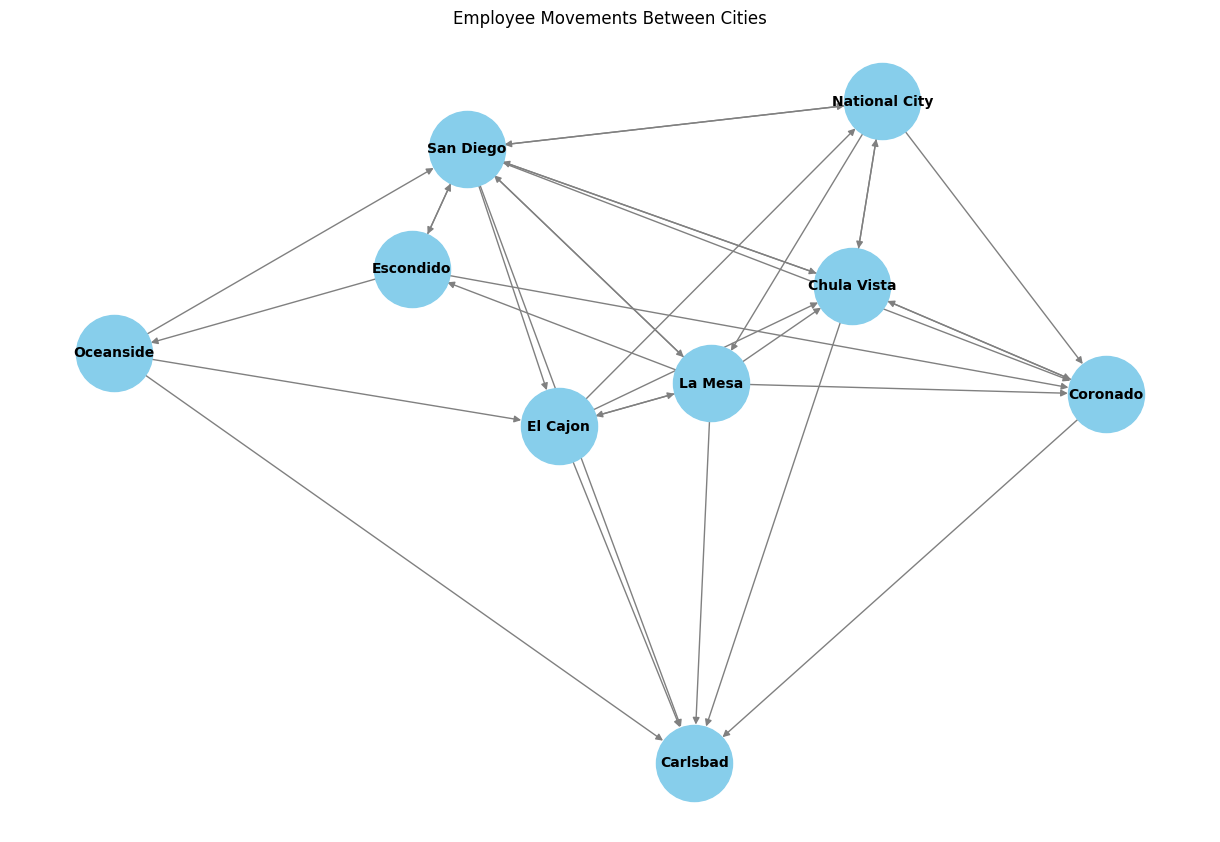

In [133]:
# Create an empty directed graph
G = nx.DiGraph()

# Add edges between cities for each individual who has worked in multiple cities
for name, group in filtered_movements_df.groupby('Name'):
    cities = group['City'].unique()
    if len(cities) > 1:
        for i in range(len(cities) - 1):
            G.add_edge(cities[i], cities[i + 1])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title("Employee Movements Between Cities")
plt.show()


In [932]:
'''filtered_df.loc[filtered_df['Job title'].str.contains(position, case=False, na=False), 'Job title'] = position
filtered_df['Job title'].unique()'''

"filtered_df.loc[filtered_df['Job title'].str.contains(position, case=False, na=False), 'Job title'] = position\nfiltered_df['Job title'].unique()"

In [135]:
grouped_filtered_df = df.groupby(['Year', 'City']).agg(
    PositionCount=('Job title', 'size'),
    MedianWages=('Adjusted regular pay + other pay + benefits', 'median')
).reset_index()

grouped_filtered_df.columns = ['Year', 'City', 'NumEmpls', 'AdjMedianWage']
grouped_filtered_df

,Year,City,NumEmpls,AdjMedianWage
0,2011,Carlsbad,125,131101.530000
1,2011,Coronado,59,128222.020000
2,2011,El Cajon,156,104571.345000
3,2011,Escondido,166,119677.190000
4,2011,La Mesa,90,110009.825000
...,...,...,...,...
106,2023,Coronado,73,102240.497491
107,2023,El Cajon,173,110013.362370
108,2023,Escondido,165,109659.811078
109,2023,Oceanside,242,122782.520033


In [136]:

grouped_filtered_df['NumEmpls%Chg'] = grouped_filtered_df.groupby(['City'])['NumEmpls'].pct_change()
grouped_filtered_df['AdjMedianWage%Chg'] = grouped_filtered_df.groupby(['City'])['AdjMedianWage'].pct_change()

#grouped_filtered_df.to_csv(f"C:/Users/Ericm\PycharmProjects\wageData\.venv\Scripts/{position}_RoC.csv")

grouped_filtered_df

,Year,City,NumEmpls,AdjMedianWage,NumEmpls%Chg,AdjMedianWage%Chg
0,2011,Carlsbad,125,131101.530000,NaN,NaN
1,2011,Coronado,59,128222.020000,NaN,NaN
2,2011,El Cajon,156,104571.345000,NaN,NaN
3,2011,Escondido,166,119677.190000,NaN,NaN
4,2011,La Mesa,90,110009.825000,NaN,NaN
...,...,...,...,...,...,...
106,2023,Coronado,73,102240.497491,0.000000,0.006972
107,2023,El Cajon,173,110013.362370,0.061350,0.112465
108,2023,Escondido,165,109659.811078,-0.093407,0.008500
109,2023,Oceanside,242,122782.520033,-0.016260,0.012622


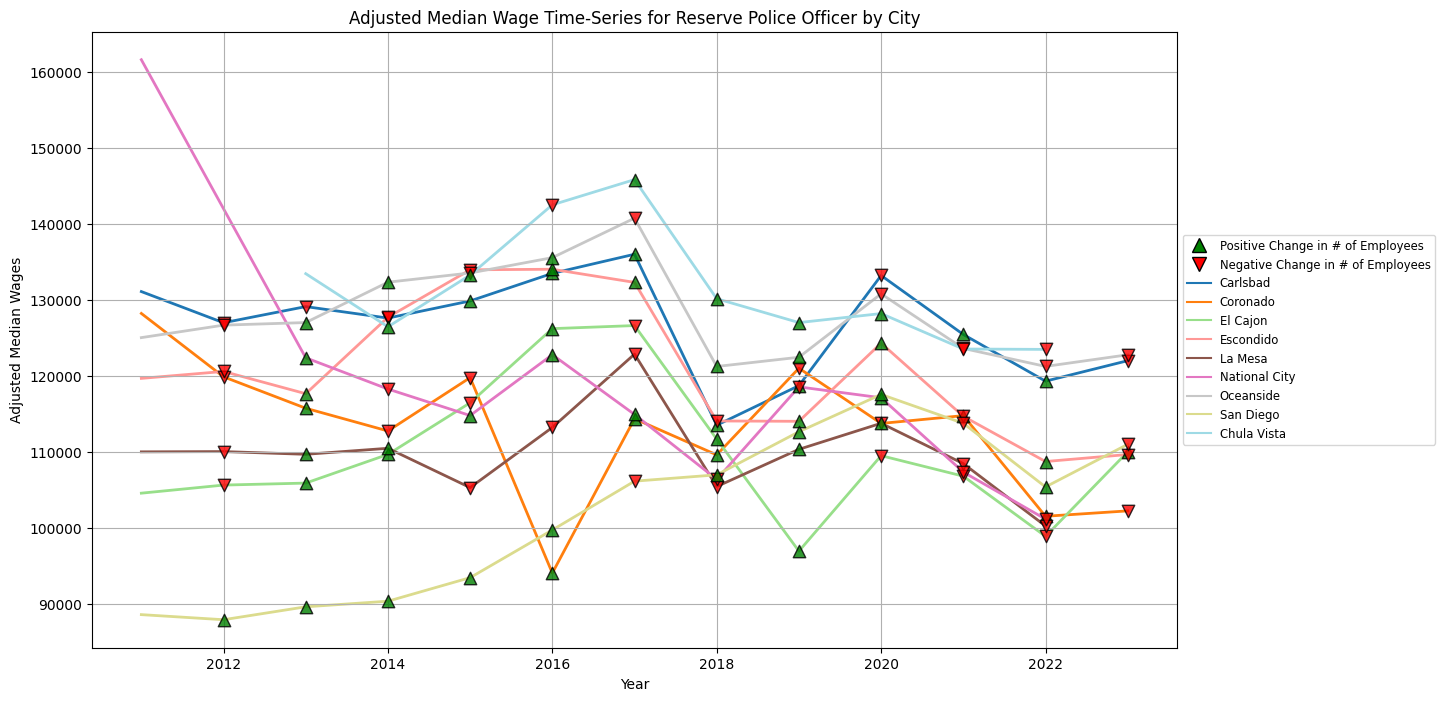

In [137]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# If position is not null, filter for that position only
def plot_wage_timeseries(df, position, filter, save_path=None):
    # Convert columns to appropriate types
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['NumEmpls%Chg'] = pd.to_numeric(df['NumEmpls%Chg'], errors='coerce')
    df['AdjMedianWage'] = pd.to_numeric(df['AdjMedianWage'], errors='coerce')
    
    # Filter by position if provided
    if filter:
        df = df[df['Job title'] == filter]
    
    # Get a list of cities in the dataset
    cities = df['City'].unique()
    
    # Use a distinct color map that can generate unique colors for each city
    num_cities = len(cities)
    cmap = plt.get_cmap('tab20', num_cities)  # 'tab20' is good for categorical data with many distinct colors
    
    # Plotting
    plt.figure(figsize=(14, 8))

    city_colors = {}

    for i, city in enumerate(cities):
        city_data = df[df['City'] == city]
        
        # Separate the data into positive and negative employee change
        positive_change = city_data[city_data['NumEmpls%Chg'] > 0]
        negative_change = city_data[city_data['NumEmpls%Chg'] <= 0]
        
        # Assign and store a unique color for each city from the colormap
        color = cmap(i)
        city_colors[city] = color
        
        # Plot time-series for the city without markers on the line
        plt.plot(city_data['Year'], city_data['AdjMedianWage'], label=city, color=color, linestyle='-', linewidth=2, zorder=1)
        
        # Overlay smaller markers for positive and negative employee changes with higher zorder
        plt.scatter(positive_change['Year'], positive_change['AdjMedianWage'], 
                    color='green', marker='^', s=80, edgecolor='black', alpha=0.8, zorder=2)
        plt.scatter(negative_change['Year'], negative_change['AdjMedianWage'], 
                    color='red', marker='v', s=80, edgecolor='black', alpha=0.8, zorder=2)
    
    plt.title(f'Adjusted Median Wage Time-Series for {position} by City')
    plt.xlabel('Year')
    plt.ylabel('Adjusted Median Wages')
    
    # Create custom handles for the legend to only show one instance of the markers
    custom_handles = [
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Positive Change in # of Employees', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Negative Change in # of Employees', markeredgecolor='black')
    ]
    
    # Add city-specific handles with unique colors
    city_handles = [plt.Line2D([0], [0], color=city_colors[city], label=city) for city in cities]
    
    plt.legend(handles=custom_handles + city_handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to avoid cutting off the legend
        
    plt.show()

# Example usage with your DataFrame
plot_wage_timeseries(grouped_filtered_df, position=position, filter = None, save_path=f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/{position.replace(' ', '')}WagesNumEmployeesViz.pdf")

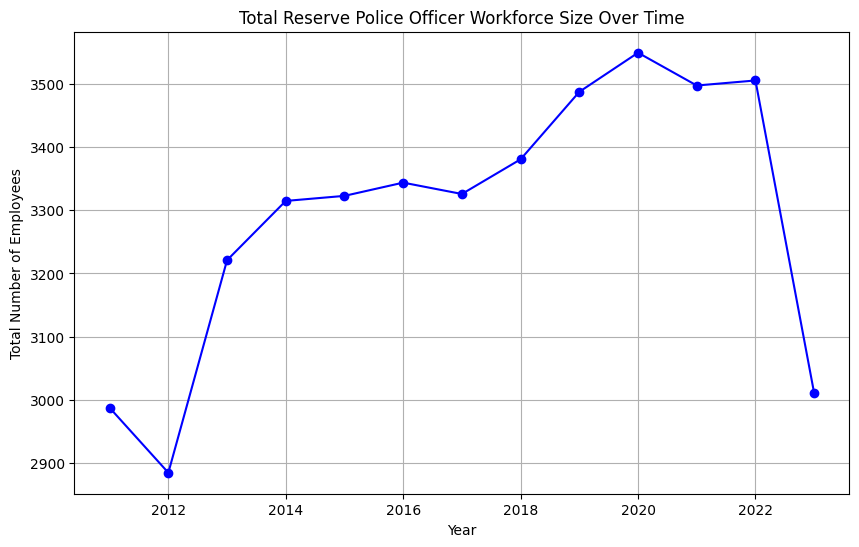

In [138]:
# Calculate the total number of employees for each year
total_workforce_new = grouped_filtered_df.groupby('Year')['NumEmpls'].sum()

# Plot the time-series of total workforce size
plt.figure(figsize=(10, 6))
plt.plot(total_workforce_new.index, total_workforce_new.values, marker='o', linestyle='-', color='b')
plt.title(f'Total {position} Workforce Size Over Time')
plt.xlabel('Year')
plt.ylabel('Total Number of Employees')
plt.grid(True)
plt.savefig(f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/{position.replace(' ', '')}NumEmployeesViz.pdf")
plt.show()

In [139]:
import pandas as pd
import statsmodels.api as sm

# Convert 'City' to numeric codes if necessary
grouped_filtered_df['City'] = grouped_filtered_df['City'].astype('category').cat.codes
grouped_filtered_df['Year'] = pd.to_numeric(grouped_filtered_df['Year'])

# Create a lagged variable for NumEmpls%Chg by shifting it by 1 year within each city
#grouped_filtered_df['NumEmpls%Chg_Lagged'] = grouped_filtered_df.groupby('City')['NumEmpls%Chg'].shift(1)

# Define the dependent variable
y = pd.to_numeric(grouped_filtered_df['AdjMedianWage%Chg'], errors='coerce')

# Define the independent variables
X = grouped_filtered_df[['City', 'Year', 'NumEmpls%Chg']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Drop missing values that resulted from the lagging operation
X = X.dropna()
y = y[X.index]

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      AdjMedianWage%Chg   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.632
Date:                Wed, 21 Aug 2024   Prob (F-statistic):             0.0542
Time:                        16:27:21   Log-Likelihood:                 127.05
No. Observations:                 102   AIC:                            -246.1
Df Residuals:                      98   BIC:                            -235.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.9991      4.342      0.921   